# Evaluation of Nanopore-base drug resistance prediction

This notebook contains the figures and tables for the drug resistance prediction component of our paper *Nanopore sequencing for _Mycobacterium tuberculosis_ public health applications*

In [43]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

phenosheet = "../../../../docs/phenotypes.csv"#snakemake.input.phenosheet
plt.style.use("ggplot")
CONF = 0.95

Load the concordance data. This gives us the mykrobe Illumina and Nanopore calls for each sample-drug combination.

In [44]:
covdf = pd.read_csv("../../../../data/QC/report/coverage.csv", index_col="sample")

In [45]:
concordance_files = [Path(p) for p in Path("../../results/concordance/").rglob("*.csv")]

In [46]:
frames = []
for p in concordance_files:
    sample, tool = p.name.split(".")[0:2]
    tech = p.parts[-3]
    site = p.parts[-2]
    table = pd.read_csv(p)
    table["sample"] = sample
    table["tool"] = tool
    table["tech"] = tech
    table["site"] = site
    frames.append(table)

In [47]:
calls = pd.concat(frames)
calls.reset_index(drop=True, inplace=True)
valid_samples = set(calls["sample"])

In [48]:
calls

,drug,classification,true_call,test_call,sample,tool,tech,site
0,Ofloxacin,TN,S,U,17_616026,drprg,illumina,birmingham
1,Moxifloxacin,TN,S,U,17_616026,drprg,illumina,birmingham
2,Isoniazid,TN,S,U,17_616026,drprg,illumina,birmingham
3,Kanamycin,TN,S,S,17_616026,drprg,illumina,birmingham
4,Ethambutol,TN,S,U,17_616026,drprg,illumina,birmingham
...,...,...,...,...,...,...,...,...
6639,Ciprofloxacin,TN,S,S,R37765,mykrobe,nanopore,south_africa
6640,Pyrazinamide,TN,S,S,R37765,mykrobe,nanopore,south_africa
6641,Rifampicin,TP,R,R,R37765,mykrobe,nanopore,south_africa
6642,Amikacin,TN,S,S,R37765,mykrobe,nanopore,south_africa


Load the phenotype information

In [49]:
pheno = pd.read_csv(phenosheet).melt(
    id_vars=["sample"], var_name="drug", value_name="phenotype"
)
arr = []
for r in pheno["phenotype"]:
    if pd.isna(r):
        arr.append(r)
    elif r.upper() in ("R", "S"):
        arr.append(r.upper())
    else:
        arr.append(None)
pheno["phenotype"] = arr
pheno = pheno.loc[pheno["sample"].isin(valid_samples)]
pheno.set_index(["sample", "drug"], drop=False, inplace=True)
pheno.sort_index(inplace=True)

In [50]:
DRUGS = sorted(set(calls["drug"]))

In [51]:
d = {}
add_lpa = False
exclude = {}#{"pyrazinamide", "moxifloxacin"}
samples_with_pheno = []
for drug in map(str.lower, DRUGS):
    if drug in exclude:
        continue
    samples = list(pheno.query("drug == @drug").dropna()["sample"])
    samples_with_pheno.extend(samples)
    if samples:
        d[drug.upper()] = samples
    if add_lpa:
        lpa = drug + "-lpa"
        samples = list(pheno.query("drug == @lpa").dropna()["sample"])
        if samples:
            d[lpa.upper()] = samples

In [52]:
upset_data = upsetplot.from_contents(d)

## Figure 1
Culture-based drug susceptibility data available for samples. Each row is a drug, and the columns represent a set of samples that have phenotype information for those drugs with a filled cell. The top panel shows the number of samples in the set for that combination of drugs. The bar plot in the left panel shows the number of samples with phenotype information for that drug.

In [53]:
tbl = pd.DataFrame([(f"{k.split('-')[0].capitalize()}{''.join(map(str.upper, k.partition('-')[-2:]))}", len(v)) for k, v in sorted(d.items())], columns=["Drug", "Count"])

In [54]:
print(tbl.to_latex(index=False))

\begin{tabular}{lr}
\toprule
        Drug &  Count \\
\midrule
    Amikacin &     89 \\
 Capreomycin &     52 \\
  Ethambutol &     91 \\
   Isoniazid &     99 \\
   Kanamycin &     52 \\
Moxifloxacin &      1 \\
   Ofloxacin &     87 \\
Pyrazinamide &      1 \\
  Rifampicin &     92 \\
Streptomycin &     91 \\
\bottomrule
\end{tabular}



In [55]:
# tbl.to_csv("/Users/michaelhall/Downloads/available-dst.csv", index=False)

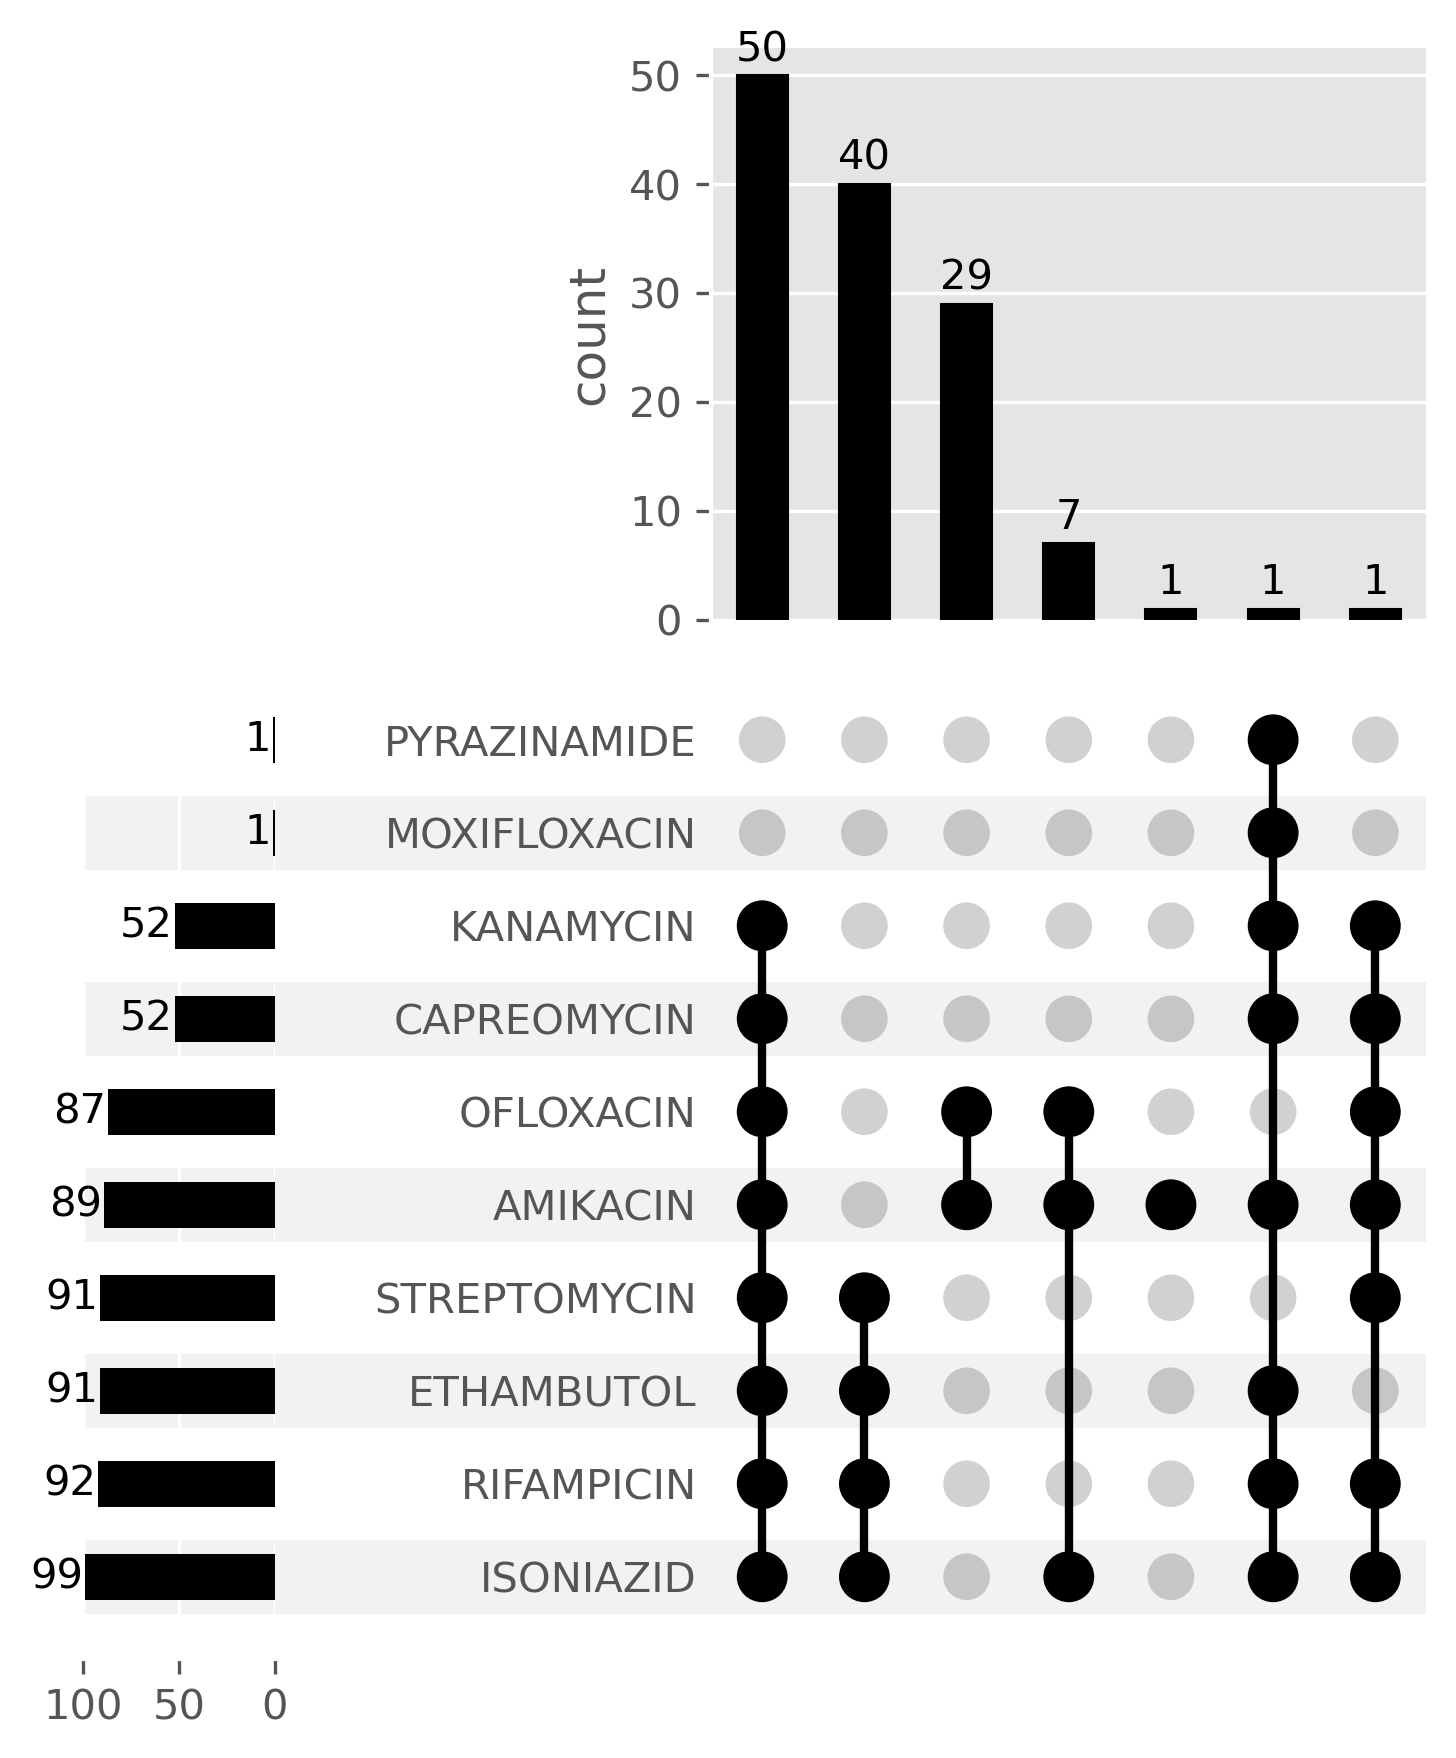

In [56]:
fig, ax = plt.subplots()
p = upsetplot.plot(
    upset_data,
    fig=fig,
    sort_by="cardinality",
    orientation="horizontal",
    show_counts=True,
)
p["intersections"].set_ylabel("count")
ax.axis("off")
# fig.set_figwidth(8)
# fig.set_figheight(10)
p["totals"].set_xticks([0, 50, 100])
fig.set_dpi(300)

In [57]:
# fig.savefig(snakemake.output.dst_data)

## Resistance prediction performance of mykrobe
mykrobe has been rigorously evaluated on datasets which much better/broader phenotype availability. However, it's prediction ability on ONT data has only been validated with 5 samples. We look to validate it's performance on this dataset's Illumina and ONT data, for those drugs/samples where phenotype data is available. 
We will also discuss the causes for any discrepencies and look to COMPASS/bcftools calls for adjudication if possible.

The figure for this section will basically be a copy of [5c/d from the mykrobe nature comms paper](https://www.nature.com/articles/ncomms10063#Fig5) (side-by-side bar charts showing resistant/susceptible samples, with stacked bars indicating FPs and FNs)

In [58]:
# taken from https://apps.who.int/iris/bitstream/handle/10665/130918/9789241548809_eng.pdf?sequence=1&isAllowed=y
drug_abbrev = {
    "ethambutol": "E",
    "isoniazid": "H",
    "pyrazinamide": "Z",
    "rifampicin": "R",
    "streptomycin": "S",
    "kanamycin": "Km",
    "amikacin": "Am",
    "ofloxacin": "Ofx",
    "capreomycin": "Cm",
    "moxifloxacin": "Mfx",
    "ciprofloxacin": "Cfx",
}
ignore_drugs = {"pyrazinamide", "moxifloxacin"}


class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    Failed = "F"

    def __str__(self) -> str:
        return self.value


class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value


class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
        unknown_is_resistant: bool = False,
        failed_is_resistant: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.unknown_is_resistant = unknown_is_resistant
        self.failed_is_resistant = failed_is_resistant
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)

        if self.unknown_is_resistant:
            self.resistant.add(Prediction.Unknown)
        else:
            self.susceptible.add(Prediction.Unknown)

        if self.failed_is_resistant:
            self.resistant.add(Prediction.Failed)
        else:
            self.susceptible.add(Prediction.Failed)

    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative



@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def ppv(self) -> Tuple[float, float, float]:
        """Also known as precision"""
        try:
            ppv = self.tp / (self.tp + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fp)
            return ppv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def npv(self) -> Tuple[float, float, float]:
        """Negative predictive value"""
        try:
            npv = self.tn / (self.tn + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fn)
            return npv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def sensitivity(self) -> float:
        """Also known as recall and true positive rate (TPR)"""
        try:
            return self.tp / self.num_positive()
        except ZeroDivisionError:
            return None

    def specificity(self) -> float:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            return self.tn / self.num_negative()
        except ZeroDivisionError:
            return None

    def fnr(self) -> Tuple[float, float, float]:
        """False negative rate or VME (very major error rate)"""
        try:
            fnr = self.fn / self.num_positive()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fn, n_f=self.tp)
            return fnr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def fpr(self) -> Tuple[float, float, float]:
        """False positive rate or ME (major error rate)"""
        try:
            fpr = self.fp / self.num_negative()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fp, n_f=self.tn)
            return fpr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = CONF) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z ** 2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

In [59]:
# exclude_samples = set()
# for k, c in Counter(clf_df.query("classification in ('FP','FN') and technology=='nanopore' and tool=='drprg'")["sample"]).items():
#     if c>1:
#         exclude_samples.add(k)

In [60]:
pheno_clf = []
minor_is_susceptible = False
unknown_is_resistant = False
failed_is_resistant = False
classifier = Classifier(unknown_is_resistant=unknown_is_resistant, minor_is_susceptible=minor_is_susceptible)

for ix, row in calls.iterrows():
    drug = row["drug"].lower()
    if drug in ignore_drugs:
        continue

    sample = row["sample"]
#     if sample in exclude_samples:
#         continue
    try:
        ph = pheno.loc[(sample, drug), "phenotype"]
        if pd.isna(ph).all():
            continue
        else:
            truth = Prediction(ph[0])
    except KeyError:
        continue
    
    tech = row["tech"]
    if tech == "illumina":
        covg = covdf.loc[sample]["illumina_covg"]
    else:
        covg = covdf.loc[sample]["nanopore_covg"]
    
    pred = Prediction(row["test_call"])    
    clf = classifier.from_predictions(truth, pred)

    pheno_clf.append((sample, drug, str(clf), tech, covg, row["tool"], row["site"]))

In [61]:
clf_df = pd.DataFrame(
    pheno_clf, columns=["sample", "drug", "classification", "technology", "coverage", "tool", "site"]
)

In [62]:
pheno_cms = defaultdict()
TOOLS = ["drprg", "mykrobe"]
TECHS = ["nanopore", "illumina"]
PHENO_DRUGS = set()

for drug, tech, tool in product(set(clf_df["drug"]), TECHS, TOOLS):
    s = clf_df.query("drug == @drug and technology == @tech and tool == @tool").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    pheno_cms[(drug, tech, tool)] = cm
    PHENO_DRUGS.add(drug)
    
PHENO_DRUGS = sorted(PHENO_DRUGS)

In [63]:
metrics = []
for (drug, tech, tool), cm in pheno_cms.items():
        #         sensitivity = cm.sensitivity()
        #         specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, tech, tool, ppv, npv, vme, me))

summary_cols = [
    "drug",
    "tech",
    "tool",
    "PPV",
    "NPV",
    "FNR",
    "FPR",
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "tech", "tool"], var_name="metric")

## Figure 2
Number of resistant (left) and susceptible (right) phenotypes correctly identified by mykrobe from Illumina (blue) and Nanopore (purple) data from the same samples. The red bars indicate missed (FN) or incorrect (FP) predictions. The x-axis shows the drugs with available phenotype data that mykrobe also makes predictions for. E - ethambutol; H - isoniazid; Z - pyrazinamide; R - rifampicin; S - streptomycin; Km - kanamycin; Am - amikacin; Ofx - ofloxacin; Cm - capreomycin; Mfx - moxifloxacin.

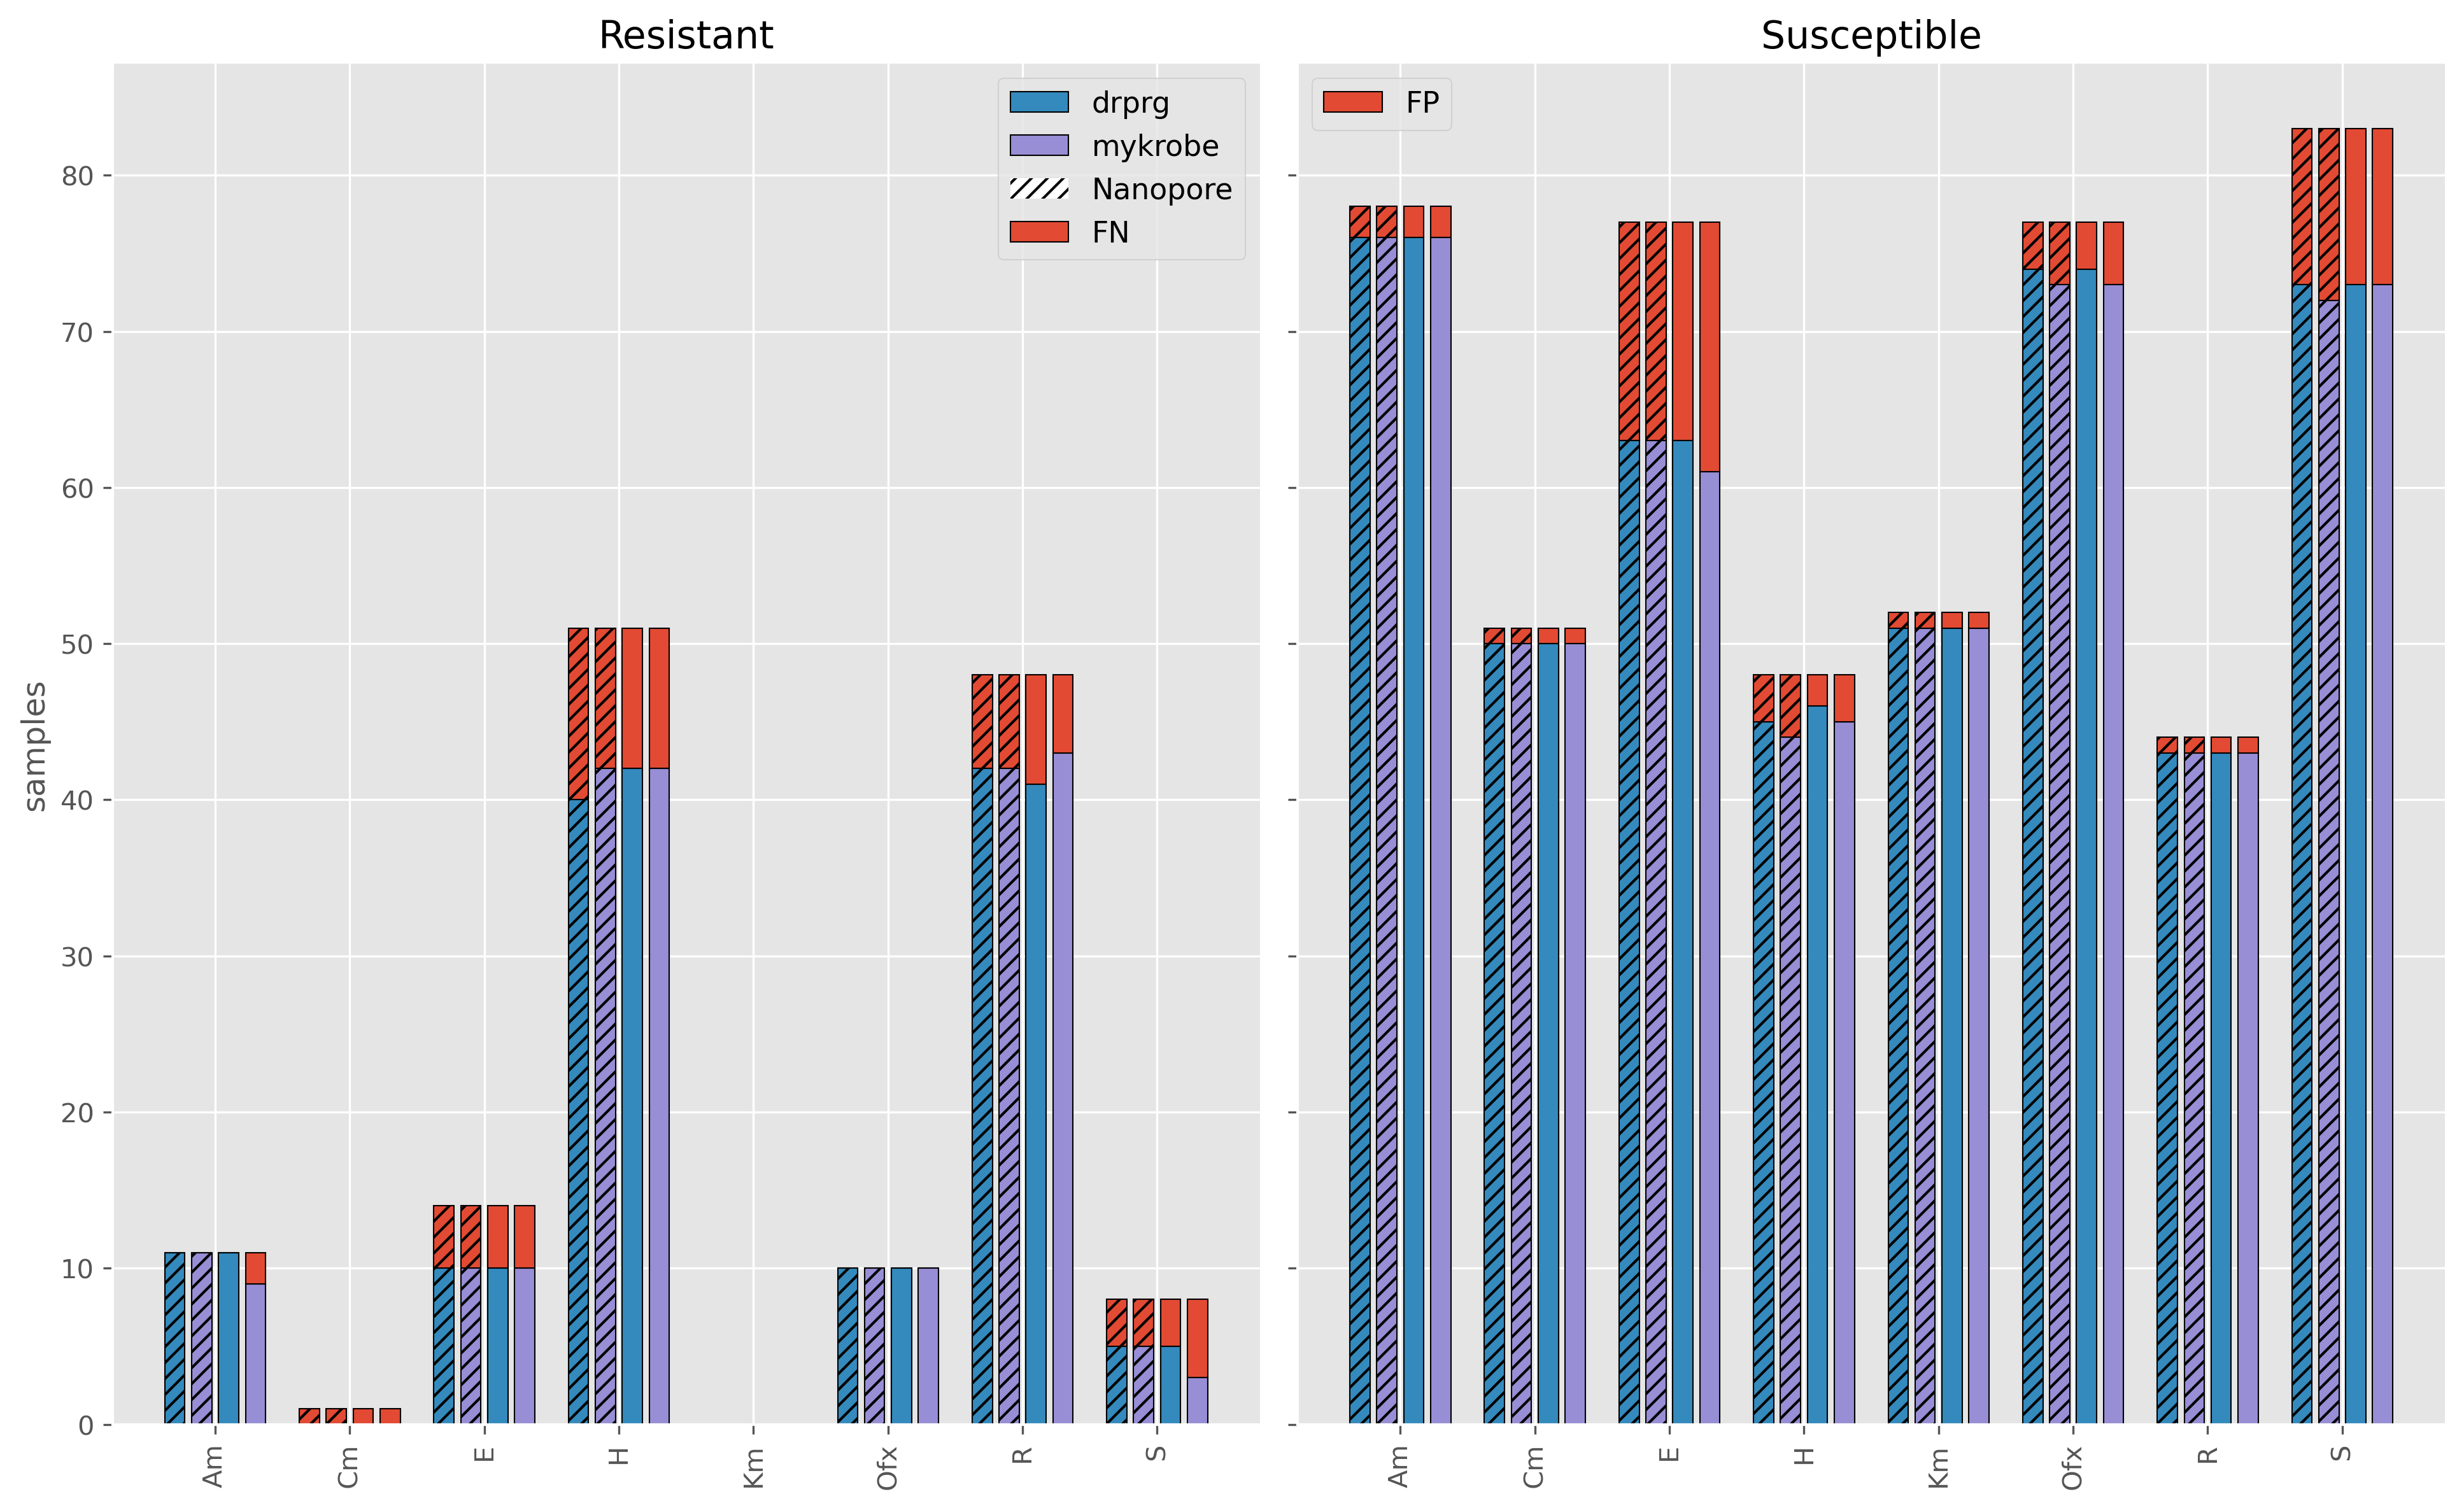

In [64]:
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
red = ggplot_cm[0]
blue = ggplot_cm[1]
purple = ggplot_cm[2]
black = ggplot_cm[3]
edgecol = "black"
cmap = {"drprg": blue, "mykrobe": purple}
# i = 0
# for tool in TOOLS:
#     c = ggplot_cm[i]
#     if c in (red, black):
#         i += 1
#         c = ggplot_cm[i]
#     cmap[tool] = c
#     i += 1

fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.15
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    tps = [pheno_cms[(d, tech, tool)].tp for d in PHENO_DRUGS]
    fps = [pheno_cms[(d, tech, tool)].fp for d in PHENO_DRUGS]
    tns = [pheno_cms[(d, tech, tool)].tn for d in PHENO_DRUGS]
    fns = [pheno_cms[(d, tech, tool)].fn for d in PHENO_DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=tps,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )

    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=tns,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "nanopore":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

fps_bar.set_label("FP")
fns_bar.set_label("FN")
labels = [drug_abbrev[d] for d in PHENO_DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(2, hatch_leghandle)
leglabels.insert(2, "Nanopore")
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})
sns.despine()
plt.tight_layout()

In [101]:
clf_df.query("drug=='streptomycin' and classification=='FP' and tool=='mykrobe'")

,sample,drug,classification,technology,coverage,tool,site
1386,mada_1-19,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1402,mada_1-20,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1485,mada_1-39,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1501,mada_1-41,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1573,mada_1-53,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1581,mada_1-54,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1597,mada_1-7,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1759,mada_135,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1833,mada_2-31,streptomycin,FP,illumina,60.00,mykrobe,madagascar
1869,mada_2-53,streptomycin,FP,illumina,60.00,mykrobe,madagascar


In [96]:
pheno.query("sample=='mada_1-21'")

sample               drug phenotype
sample    drug                                                     
mada_1-21 amikacin           mada_1-21           amikacin         S
          amikacin-lpa       mada_1-21       amikacin-lpa       NaN
          capreomycin        mada_1-21        capreomycin         R
          capreomycin-lpa    mada_1-21    capreomycin-lpa       NaN
          ciprofloxacin-lpa  mada_1-21  ciprofloxacin-lpa       NaN
          ethambutol         mada_1-21         ethambutol         S
          ethambutol-lpa     mada_1-21     ethambutol-lpa       NaN
          ethionamide        mada_1-21        ethionamide       NaN
          isoniazid          mada_1-21          isoniazid         R
          isoniazid-lpa      mada_1-21      isoniazid-lpa         S
          kanamycin          mada_1-21          kanamycin         S
          kanamycin-lpa      mada_1-21      kanamycin-lpa       NaN
          moxifloxacin       mada_1-21       moxifloxacin       NaN
          moxifloxacin-lpa   mada_1-21   moxifloxacin-lpa       NaN
          ofloxacin          mada_1-21          ofloxacin         S
          ofloxacin-lpa      mada_1-21      ofloxacin-lpa       NaN
          pas                mada_1-21                pas         R
          pyrazinamide       mada_1-21       pyrazinamide       NaN
          rifampicin         mada_1-21         rifampicin         R
          rifampicin-lpa     mada_1-21     rifampicin-lpa         S
          streptomycin       mada_1-21       streptomycin         S
          thioacetazone      mada_1-21      thioacetazone         R

In [67]:
# fig.savefig("pheno_concordance_plot.png")

In [68]:
counts = clf_df.groupby(["drug", "tool", "technology", "classification"])["sample"].count()
table = summary.set_index(["drug", "tech", "tool", "metric"])["value"].unstack().reset_index()

for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["tech"], row["tool"])
    cm = pheno_cms[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn
    
for k in ["drug", "tech", "tool"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = ["drug", "tech", "tool", "PPV", "NPV", "FNR", "FPR", "TP", "TN", "FN", "FP"]
table = table[summary_cols]
table.rename(columns={"tech": "technology"}, inplace=True)

This table summarises the results visualised above in Figure 2

In [69]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    npv = cm.npv()
    ppv = cm.ppv()
    vme = cm.fnr()
    me = cm.fpr()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            row["technology"],
            row["tool"],
            fn_str,
            fp_str,
            ci_str(vme),
            ci_str(me),
            ci_str(ppv),
            ci_str(npv),
        )
    )
pretty_cols = [
    "Drug",
    "Technology",
    "Tool",
    "FN(R)",
    "FP(S)",
    "FNR(95% CI)",
    "FPR(95% CI)",
    "PPV(95% CI)",
    "NPV(95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)
table

,Drug,Technology,Tool,FN(R),FP(S),FNR(95% CI),FPR(95% CI),PPV(95% CI),NPV(95% CI)
0,Amikacin,Illumina,Drprg,0(11),2(78),0.0% (0.0-25.9%),2.6% (0.7-8.9%),84.6% (57.8-95.7%),100.0% (95.2-100.0%)
1,Amikacin,Illumina,Mykrobe,2(11),2(78),18.2% (5.1-47.7%),2.6% (0.7-8.9%),81.8% (52.3-94.9%),97.4% (91.1-99.3%)
2,Amikacin,Nanopore,Drprg,0(11),2(78),0.0% (0.0-25.9%),2.6% (0.7-8.9%),84.6% (57.8-95.7%),100.0% (95.2-100.0%)
3,Amikacin,Nanopore,Mykrobe,0(11),2(78),0.0% (0.0-25.9%),2.6% (0.7-8.9%),84.6% (57.8-95.7%),100.0% (95.2-100.0%)
4,Capreomycin,Illumina,Drprg,1(1),1(51),100.0% (20.7-100.0%),2.0% (0.3-10.3%),0.0% (0.0-79.3%),98.0% (89.7-99.7%)
5,Capreomycin,Illumina,Mykrobe,1(1),1(51),100.0% (20.7-100.0%),2.0% (0.3-10.3%),0.0% (0.0-79.3%),98.0% (89.7-99.7%)
6,Capreomycin,Nanopore,Drprg,1(1),1(51),100.0% (20.7-100.0%),2.0% (0.3-10.3%),0.0% (0.0-79.3%),98.0% (89.7-99.7%)
7,Capreomycin,Nanopore,Mykrobe,1(1),1(51),100.0% (20.7-100.0%),2.0% (0.3-10.3%),0.0% (0.0-79.3%),98.0% (89.7-99.7%)
8,Ethambutol,Illumina,Drprg,4(14),14(77),28.6% (11.7-54.6%),18.2% (11.2-28.2%),41.7% (24.5-61.2%),94.0% (85.6-97.7%)
9,Ethambutol,Illumina,Mykrobe,4(14),16(77),28.6% (11.7-54.6%),20.8% (13.2-31.1%),38.5% (22.4-57.5%),93.8% (85.2-97.6%)


## Table 1 Comparison of drug resistance predictions with culture-based phenotype

For this comparison, we assume the drug susceptibility testing phenotype is correct and evaluate mykrobe Illumina and Nanopore resistance predictions accordingly. Pyrazinamide and Moxifloxacin are excluded as phenotype information is only available for 1 sample.

FN=false negative; R=number of resistant samples; FP=false positive; S=number of susceptible samples; FNR=false negative rate; FPR=false positive rate; PPV=positive predictive value; NPV=negative predictive value; CI=Wilson score confidence interval

In [33]:
print(table.to_markdown(index=False))

| Drug         | Technology   | Tool    | FN(R)   | FP(S)   | FNR(95% CI)        | FPR(95% CI)        | PPV(95% CI)        | NPV(95% CI)          |
|:-------------|:-------------|:--------|:--------|:--------|:-------------------|:-------------------|:-------------------|:---------------------|
| Amikacin     | Illumina     | Drprg   | 0(11)   | 2(77)   | 0.0% (0.0-25.9%)   | 2.6% (0.7-9.0%)    | 84.6% (57.8-95.7%) | 100.0% (95.1-100.0%) |
| Amikacin     | Illumina     | Mykrobe | 2(11)   | 2(77)   | 18.2% (5.1-47.7%)  | 2.6% (0.7-9.0%)    | 81.8% (52.3-94.9%) | 97.4% (91.0-99.3%)   |
| Amikacin     | Nanopore     | Drprg   | 0(11)   | 2(77)   | 0.0% (0.0-25.9%)   | 2.6% (0.7-9.0%)    | 84.6% (57.8-95.7%) | 100.0% (95.1-100.0%) |
| Amikacin     | Nanopore     | Mykrobe | 0(11)   | 2(77)   | 0.0% (0.0-25.9%)   | 2.6% (0.7-9.0%)    | 84.6% (57.8-95.7%) | 100.0% (95.1-100.0%) |
| Capreomycin  | Illumina     | Drprg   | 0(0)    | 1(51)   | -                  | 2.0% (0.3-10.3%)   | 0.0% (0.

In [34]:
print(table.to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
        Drug & Technology &    Tool &  FN(R) &  FP(S) &        FNR(95\% CI) &        FPR(95\% CI) &        PPV(95\% CI) &          NPV(95\% CI) \\
\midrule
    Amikacin &   Illumina &   Drprg &  0(11) &  2(77) &   0.0\% (0.0-25.9\%) &    2.6\% (0.7-9.0\%) & 84.6\% (57.8-95.7\%) & 100.0\% (95.1-100.0\%) \\
    Amikacin &   Illumina & Mykrobe &  2(11) &  2(77) &  18.2\% (5.1-47.7\%) &    2.6\% (0.7-9.0\%) & 81.8\% (52.3-94.9\%) &   97.4\% (91.0-99.3\%) \\
    Amikacin &   Nanopore &   Drprg &  0(11) &  2(77) &   0.0\% (0.0-25.9\%) &    2.6\% (0.7-9.0\%) & 84.6\% (57.8-95.7\%) & 100.0\% (95.1-100.0\%) \\
    Amikacin &   Nanopore & Mykrobe &  0(11) &  2(77) &   0.0\% (0.0-25.9\%) &    2.6\% (0.7-9.0\%) & 84.6\% (57.8-95.7\%) & 100.0\% (95.1-100.0\%) \\
 Capreomycin &   Illumina &   Drprg &   0(0) &  1(51) &                  - &   2.0\% (0.3-10.3\%) &   0.0\% (0.0-79.3\%) & 100.0\% (92.9-100.0\%) \\
 Capreomycin &   Illumina & Mykrobe &   0(0) &  1(51) &

In [35]:
# table.to_csv(snakemake.output.pheno_concordance_csv, na_rep="-", index=False)

In [36]:
clf_df

,sample,drug,classification,technology,coverage,tool,site
0,mada_128,isoniazid,TN,nanopore,114.55,mykrobe,madagascar
1,mada_128,ethambutol,TN,nanopore,114.55,mykrobe,madagascar
2,mada_128,streptomycin,TN,nanopore,114.55,mykrobe,madagascar
3,mada_128,rifampicin,TN,nanopore,114.55,mykrobe,madagascar
4,mada_1-2,ofloxacin,TN,nanopore,67.51,mykrobe,madagascar
...,...,...,...,...,...,...,...
2575,R24100,amikacin,TN,illumina,60.00,drprg,south_africa
2576,R27252,ofloxacin,TN,illumina,60.00,drprg,south_africa
2577,R27252,amikacin,TN,illumina,60.00,drprg,south_africa
2578,R20574,ofloxacin,FP,illumina,60.00,drprg,south_africa


In [70]:
data = []

step = 10
tech = "nanopore"
start = round_down_to_base(
    clf_df.query("technology==@tech")["coverage"].min(), base=step
)
stop = (
    round_up_to_base(clf_df.query("technology==@tech")["coverage"].max(), base=step)
    + step
)
coverages = np.arange(start=start, stop=stop, step=step)
for i, covg in enumerate(coverages[:-1]):
    next_cov = coverages[i + 1]
    subdf = clf_df.query(
        "coverage > @covg and coverage <= @next_cov and technology == @tech"
    )
    n_samples = len(set(subdf['sample']))
    for tool in TOOLS:
        s = subdf.query("tool == @tool").value_counts(subset="classification")
        cm = ConfusionMatrix.from_series(s)
        total = sum(cm.ravel())
        
        data.append((covg, "FP", cm.fp / total, tech, n_samples, tool))
        data.append((covg, "TP", cm.tp / total, tech, n_samples, tool))
        data.append((covg, "FN", cm.fn / total, tech, n_samples, tool))
        data.append((covg, "TN", cm.tn / total, tech, n_samples, tool))


tech = "illumina"
start = round_down_to_base(
    clf_df.query("technology==@tech")["coverage"].min(), base=step
)
stop = round_up_to_base(clf_df.query("technology==@tech")["coverage"].max(), base=step)
coverages = np.arange(start=start, stop=stop, step=step)
for i, covg in enumerate(coverages[:-1]):
    next_cov = coverages[i + 1]
    subdf = clf_df.query(
        "coverage > @covg and coverage <= @next_cov and technology == @tech"
    )
    n_samples = len(set(subdf['sample']))
    for tool in TOOLS:
        s = subdf.query("tool == @tool").value_counts(subset="classification")
        cm = ConfusionMatrix.from_series(s)
        total = sum(cm.ravel())
        
        data.append((covg, "FP", cm.fp / total, tech, n_samples, tool))
        data.append((covg, "TP", cm.tp / total, tech, n_samples, tool))
        data.append((covg, "FN", cm.fn / total, tech, n_samples, tool))
        data.append((covg, "TN", cm.tn / total, tech, n_samples, tool))

summary = pd.DataFrame(
    data, columns=["coverage", "classification", "proportion", "technology", "total", "tool"]
)

Effect of Nanopore read depth on mykrobe phenotype prediction. Each point indicates the proportion (y-axis) of classifications of that type at the read depth (x-axis). Read depth is "binned". That is, read depth 40 is all samples with a read depth greater than 40 and less than or equal to 50. FP - false positive; TN - true negative; etc.

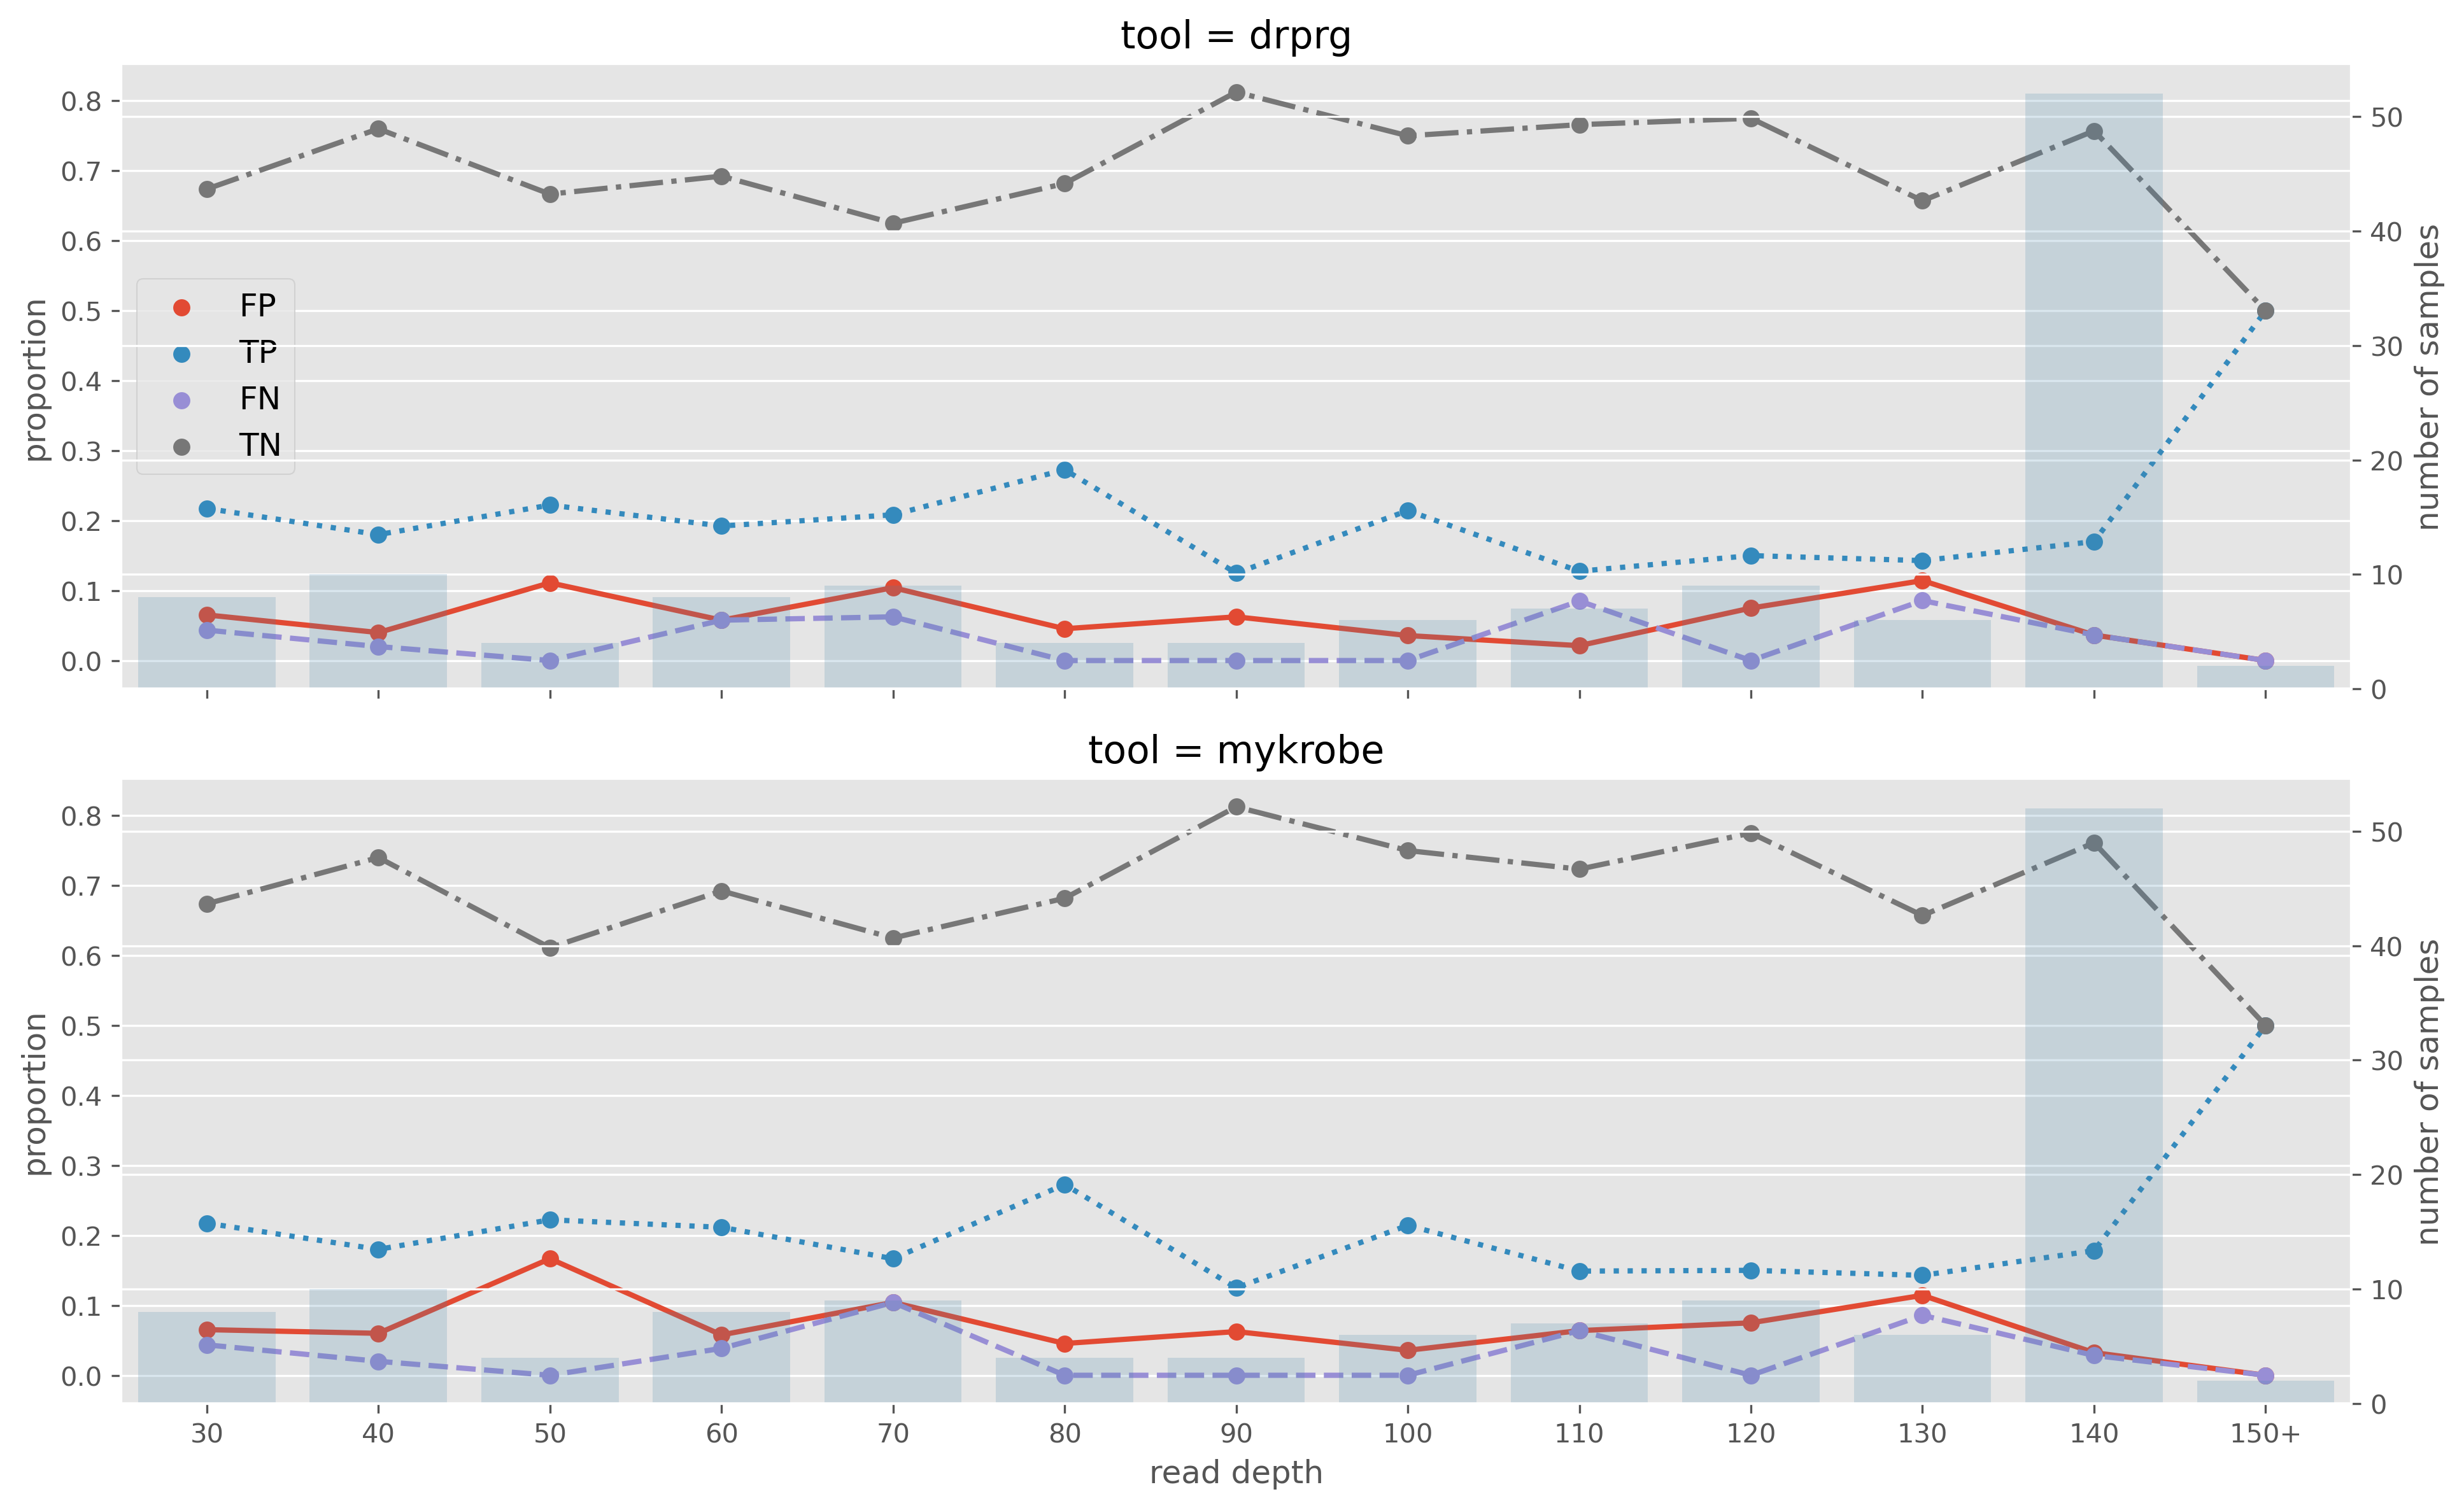

In [71]:
with sns.plotting_context(rc={"lines.linewidth": 1.1}):
    fig, axes = plt.subplots(nrows=len(TOOLS), figsize=(13, 8), dpi=300, sharex=True)
    
    for tool, ax in zip(TOOLS, axes.flatten()):
        x = "coverage"
        y = "proportion"
        hue = "classification"
        tech = "nanopore"
        linestyles = ["solid", "dotted", "dashed", "dashdot"]
        data = summary.query("technology == @tech and tool == @tool")
        sns.pointplot(
            data=data,
            x=x,
            y=y,
            hue=hue,
            ax=ax,
            linestyles=linestyles,
            alpha=0.9,
        )
        ax.set_xlabel("")
        ax.set(title=f"tool = {tool}")

        ax2 = ax.twinx()
        sns.barplot(data=data, x=x, y="total", ax=ax2, color=blue, alpha=0.2)
        ax2.set_ylabel("number of samples")
        ax.legend(loc="center left", fontsize=12)
        
    xlabels = ax2.get_xticklabels()
    xlabels[-1].set_text(xlabels[-1].get_text() + "+")
    ax2.set_xticklabels(xlabels)
    ax.set_xlabel("read depth")
    ax.get_legend().remove()
    plt.tight_layout()

In [72]:
# fig.savefig(snakemake.output.pheno_coverage_plot)

# Concordance of mykrobe Nanopore resistance prediction with Illumina
Having proven mykrobe's ability to predict resistance for select drugs with ONT, we look at the concordance of ONT-based predictions with Illumina-based ones. We aim to answer to main questions here: 1) Are ONT predictions concordant with Illumina and 2) does ONT depth of coverage impact prediction capabilities and, if so, what is the coverage threshold for this impact?
We will also discuss the causes for any discrepencies and look to COMPASS/bcftools calls for adjudication if possible.

For the figure/table of this section it might suffice to just have a table like the one in Table 1. of the recent mykrobe paper with a row for each drug and columns showing TPs, FNs etc. along with VME (95% CI), ME (95% CI), PPV and NPV

In [74]:
classes = sorted(set(calls["classification"]))
conf_mxs = defaultdict()

for drug, tool, tech in product(DRUGS, TOOLS, TECHS):
    if (tech, tool) == ("illumina", "mykrobe"):
        continue
    s = calls.query("drug == @drug and tool == @tool and tech == @tech").value_counts(subset=["classification"])
    cm = ConfusionMatrix.from_series(s)
    conf_mxs[(drug, tech, tool)] = cm

metrics = []
for (drug, tech, tool), cm in conf_mxs.items():
    #     sensitivity = cm.sensitivity()
    #     specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, ppv, npv, vme, me, tech, tool))

summary_cols = ["drug", "PPV", "NPV", "FNR", "FPR", "tech", "tool"]

summary = pd.DataFrame(metrics, columns=summary_cols).melt(
    id_vars=["drug", "tool", "tech"], var_name="metric"
)
table = summary.set_index(["drug", "tool", "tech", "metric"])["value"].unstack().reset_index()
table = table[summary_cols]

counts = calls.groupby(["drug", "tool", "tech", "classification"])["sample"].count()
for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["tech"], row["tool"])
    cm = conf_mxs[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn
    
for k in ["drug", "tech", "tool"]:
    table[k] = table[k].str.capitalize()

table

metric,drug,PPV,NPV,FNR,FPR,tech,tool,TP,FP,FN,TN
0,Amikacin,0.857143,1.000000,0.000000,0.014388,Illumina,Drprg,12,2,0,137
1,Amikacin,0.857143,1.000000,0.000000,0.014388,Nanopore,Drprg,12,2,0,137
2,Amikacin,0.857143,1.000000,0.000000,0.014388,Nanopore,Mykrobe,12,2,0,137
3,Capreomycin,0.857143,1.000000,0.000000,0.014388,Illumina,Drprg,12,2,0,137
4,Capreomycin,0.857143,1.000000,0.000000,0.014388,Nanopore,Drprg,12,2,0,137
5,Capreomycin,0.857143,1.000000,0.000000,0.014388,Nanopore,Mykrobe,12,2,0,137
6,Ciprofloxacin,1.000000,0.992593,0.058824,0.000000,Illumina,Drprg,16,0,1,134
7,Ciprofloxacin,1.000000,0.992593,0.058824,0.000000,Nanopore,Drprg,16,0,1,134
8,Ciprofloxacin,1.000000,0.992593,0.058824,0.000000,Nanopore,Mykrobe,16,0,1,134
9,Ethambutol,1.000000,0.969388,0.053571,0.000000,Illumina,Drprg,53,0,3,95


In [75]:
print(table.to_markdown(index=False))

| drug          |      PPV |      NPV |       FNR |       FPR | tech     | tool    |   TP |   FP |   FN |   TN |
|:--------------|---------:|---------:|----------:|----------:|:---------|:--------|-----:|-----:|-----:|-----:|
| Amikacin      | 0.857143 | 1        | 0         | 0.0143885 | Illumina | Drprg   |   12 |    2 |    0 |  137 |
| Amikacin      | 0.857143 | 1        | 0         | 0.0143885 | Nanopore | Drprg   |   12 |    2 |    0 |  137 |
| Amikacin      | 0.857143 | 1        | 0         | 0.0143885 | Nanopore | Mykrobe |   12 |    2 |    0 |  137 |
| Capreomycin   | 0.857143 | 1        | 0         | 0.0143885 | Illumina | Drprg   |   12 |    2 |    0 |  137 |
| Capreomycin   | 0.857143 | 1        | 0         | 0.0143885 | Nanopore | Drprg   |   12 |    2 |    0 |  137 |
| Capreomycin   | 0.857143 | 1        | 0         | 0.0143885 | Nanopore | Mykrobe |   12 |    2 |    0 |  137 |
| Ciprofloxacin | 1        | 0.992593 | 0.0588235 | 0         | Illumina | Drprg   |   16 |    0

In [76]:
print(table.to_latex(index=False))

\begin{tabular}{lrrrrllrrrr}
\toprule
         drug &      PPV &      NPV &      FNR &      FPR &     tech &    tool &  TP &  FP &  FN &  TN \\
\midrule
     Amikacin & 0.857143 & 1.000000 & 0.000000 & 0.014388 & Illumina &   Drprg &  12 &   2 &   0 & 137 \\
     Amikacin & 0.857143 & 1.000000 & 0.000000 & 0.014388 & Nanopore &   Drprg &  12 &   2 &   0 & 137 \\
     Amikacin & 0.857143 & 1.000000 & 0.000000 & 0.014388 & Nanopore & Mykrobe &  12 &   2 &   0 & 137 \\
  Capreomycin & 0.857143 & 1.000000 & 0.000000 & 0.014388 & Illumina &   Drprg &  12 &   2 &   0 & 137 \\
  Capreomycin & 0.857143 & 1.000000 & 0.000000 & 0.014388 & Nanopore &   Drprg &  12 &   2 &   0 & 137 \\
  Capreomycin & 0.857143 & 1.000000 & 0.000000 & 0.014388 & Nanopore & Mykrobe &  12 &   2 &   0 & 137 \\
Ciprofloxacin & 1.000000 & 0.992593 & 0.058824 & 0.000000 & Illumina &   Drprg &  16 &   0 &   1 & 134 \\
Ciprofloxacin & 1.000000 & 0.992593 & 0.058824 & 0.000000 & Nanopore &   Drprg &  16 &   0 &   1 & 134 \\

In [77]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    npv = cm.npv()
    ppv = cm.ppv()
    vme = cm.fnr()
    me = cm.fpr()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (row["drug"], row["tool"], row["tech"], fn_str, fp_str, ci_str(vme), ci_str(me), ci_str(ppv), ci_str(npv))
    )
pretty_cols = [
    "Drug",
    "Tool",
    "Technology",
    "FN(R)",
    "FP(S)",
    "FNR(95% CI)",
    "FPR(95% CI)",
    "PPV(95% CI)",
    "NPV(95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)
table

,Drug,Tool,Technology,FN(R),FP(S),FNR(95% CI),FPR(95% CI),PPV(95% CI),NPV(95% CI)
0,Amikacin,Drprg,Illumina,0(12),2(139),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
1,Amikacin,Drprg,Nanopore,0(12),2(139),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
2,Amikacin,Mykrobe,Nanopore,0(12),2(139),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
3,Capreomycin,Drprg,Illumina,0(12),2(139),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
4,Capreomycin,Drprg,Nanopore,0(12),2(139),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
5,Capreomycin,Mykrobe,Nanopore,0(12),2(139),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
6,Ciprofloxacin,Drprg,Illumina,1(17),0(134),5.9% (1.0-27.0%),0.0% (0.0-2.8%),100.0% (80.6-100.0%),99.3% (95.9-99.9%)
7,Ciprofloxacin,Drprg,Nanopore,1(17),0(134),5.9% (1.0-27.0%),0.0% (0.0-2.8%),100.0% (80.6-100.0%),99.3% (95.9-99.9%)
8,Ciprofloxacin,Mykrobe,Nanopore,1(17),0(134),5.9% (1.0-27.0%),0.0% (0.0-2.8%),100.0% (80.6-100.0%),99.3% (95.9-99.9%)
9,Ethambutol,Drprg,Illumina,3(56),0(95),5.4% (1.8-14.6%),0.0% (0.0-3.9%),100.0% (93.2-100.0%),96.9% (91.4-99.0%)


## Table 2 Comparison of Nanopore drug resistance predictions with Illumina predictions

For this comparison, we assume the mykrobe resistance prediction from Illumina data is correct and evaluate the Nanopore prediction accordingly.

FN=false negative; R=number of resistant samples; FP=false positive; S=number of susceptible samples; FNR=false negative rate; FPR=false positive rate; PPV=positive predictive value; NPV=negative predictive value; CI=Wilson score confidence interval

In [78]:
print(table.to_markdown(index=False))

| Drug          | Tool    | Technology   | FN(R)   | FP(S)   | FNR(95% CI)        | FPR(95% CI)       | PPV(95% CI)          | NPV(95% CI)          |
|:--------------|:--------|:-------------|:--------|:--------|:-------------------|:------------------|:---------------------|:---------------------|
| Amikacin      | Drprg   | Illumina     | 0(12)   | 2(139)  | 0.0% (0.0-24.2%)   | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Amikacin      | Drprg   | Nanopore     | 0(12)   | 2(139)  | 0.0% (0.0-24.2%)   | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Amikacin      | Mykrobe | Nanopore     | 0(12)   | 2(139)  | 0.0% (0.0-24.2%)   | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Capreomycin   | Drprg   | Illumina     | 0(12)   | 2(139)  | 0.0% (0.0-24.2%)   | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Capreomycin   | Drprg   | Nanopore     | 0(12)   | 2(139)  | 0.0% (0.0-24.2%)   | 1.4% (0.4-5.1%) 

In [79]:
print(table.to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
         Drug &    Tool & Technology &  FN(R) &   FP(S) &        FNR(95\% CI) &       FPR(95\% CI) &          PPV(95\% CI) &          NPV(95\% CI) \\
\midrule
     Amikacin &   Drprg &   Illumina &  0(12) &  2(139) &   0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
     Amikacin &   Drprg &   Nanopore &  0(12) &  2(139) &   0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
     Amikacin & Mykrobe &   Nanopore &  0(12) &  2(139) &   0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
  Capreomycin &   Drprg &   Illumina &  0(12) &  2(139) &   0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
  Capreomycin &   Drprg &   Nanopore &  0(12) &  2(139) &   0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
  Capreomycin & Mykrobe &   Nanopor

In [80]:
# table.to_csv(snakemake.output.illumina_concordance_csv, na_rep="-", index=False)

## Figure 4 
Number of resistant (left) and susceptible (right) genotypes correctly identified by mykrobe from Illumina (blue) and Nanopore (purple) data from the same samples. The genotypes are predictions from mykrobe with Illumina data. The red bars indicate missed (FN) or incorrect (FP) predictions. The x-axis shows the drugs with available phenotype data that mykrobe also makes predictions for. E - ethambutol; H - isoniazid; Z - pyrazinamide; R - rifampicin; S - streptomycin; Km - kanamycin; Am - amikacin; Ofx - ofloxacin; Cm - capreomycin; Mfx - moxifloxacin.

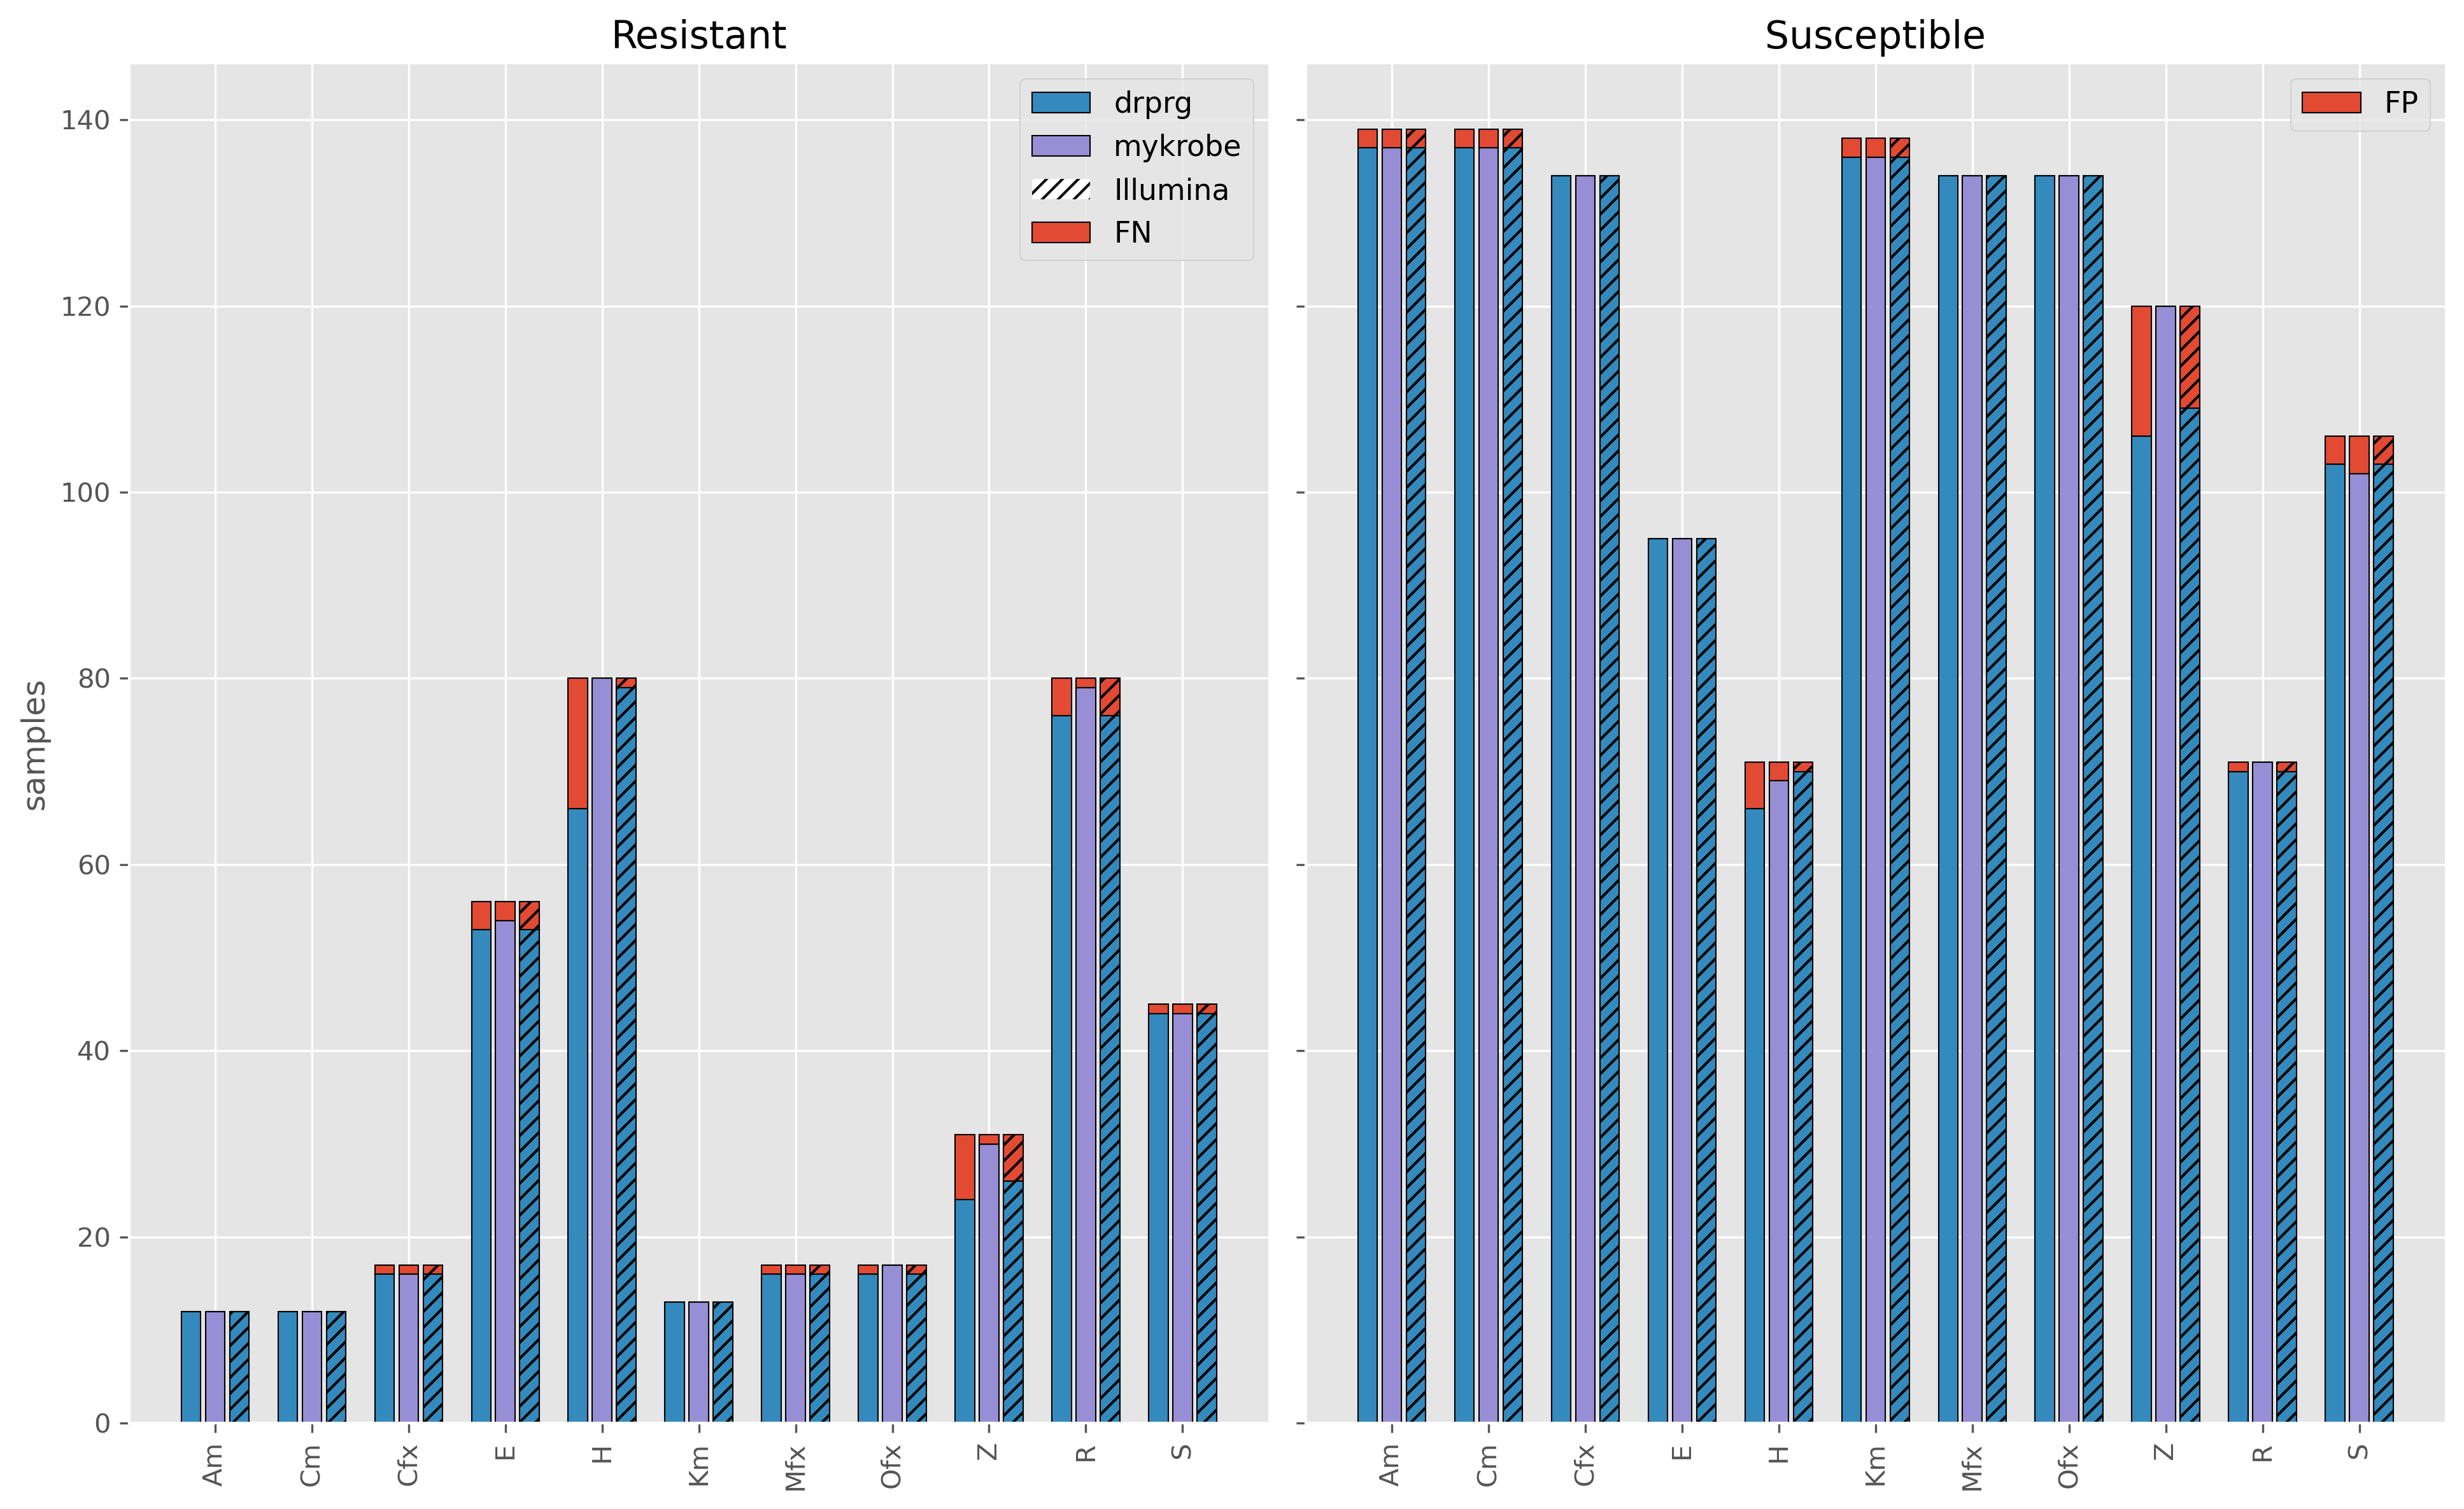

In [81]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.2
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    if (tech, tool) == ("illumina", "mykrobe"):
        continue
        
    tps = [conf_mxs[(d, tech, tool)].tp for d in DRUGS]
    fps = [conf_mxs[(d, tech, tool)].fp for d in DRUGS]
    tns = [conf_mxs[(d, tech, tool)].tn for d in DRUGS]
    fns = [conf_mxs[(d, tech, tool)].fn for d in DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=tps,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )

    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=tns,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "illumina":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

    if i == 0:
        fps_bar.set_label("FP")
        fns_bar.set_label("FN")
        
labels = [drug_abbrev[d.lower()] for d in DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(3, hatch_leghandle)
leglabels.insert(3, "Illumina")
leglabels.insert(3, leglabels.pop(1))
leghandles.insert(3, leghandles.pop(1))
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})

sns.despine()
plt.tight_layout()

In [94]:
calls.query("classification=='FP' and tool=='mykrobe'")

,drug,classification,true_call,test_call,sample,tool,tech,site
5208,Streptomycin,FP,S,R,mada_1-10,mykrobe,nanopore,madagascar
5384,Streptomycin,FP,S,R,mada_1-3,mykrobe,nanopore,madagascar
5428,Streptomycin,FP,S,R,mada_1-36,mykrobe,nanopore,madagascar
5953,Isoniazid,FP,S,R,mada_135,mykrobe,nanopore,madagascar
6393,Isoniazid,FP,S,R,R25048,mykrobe,nanopore,south_africa
6416,Kanamycin,FP,S,R,R26791,mykrobe,nanopore,south_africa
6422,Amikacin,FP,S,R,R26791,mykrobe,nanopore,south_africa
6423,Capreomycin,FP,S,R,R26791,mykrobe,nanopore,south_africa
6460,Kanamycin,FP,S,R,R27937,mykrobe,nanopore,south_africa
6466,Amikacin,FP,S,R,R27937,mykrobe,nanopore,south_africa


In [95]:
pheno.query("sample=='R27937' or sample=='R26791'")

sample               drug phenotype
sample drug                                                  
R26791 amikacin           R26791           amikacin         R
       amikacin-lpa       R26791       amikacin-lpa       NaN
       capreomycin        R26791        capreomycin       NaN
       capreomycin-lpa    R26791    capreomycin-lpa       NaN
       ciprofloxacin-lpa  R26791  ciprofloxacin-lpa       NaN
       ethambutol         R26791         ethambutol       NaN
       ethambutol-lpa     R26791     ethambutol-lpa       NaN
       ethionamide        R26791        ethionamide       NaN
       isoniazid          R26791          isoniazid       NaN
       isoniazid-lpa      R26791      isoniazid-lpa         R
       kanamycin          R26791          kanamycin       NaN
       kanamycin-lpa      R26791      kanamycin-lpa       NaN
       moxifloxacin       R26791       moxifloxacin       NaN
       moxifloxacin-lpa   R26791   moxifloxacin-lpa       NaN
       ofloxacin          R26791          ofloxacin       NaN
       ofloxacin-lpa      R26791      ofloxacin-lpa       NaN
       pas                R26791                pas       NaN
       pyrazinamide       R26791       pyrazinamide       NaN
       rifampicin         R26791         rifampicin       NaN
       rifampicin-lpa     R26791     rifampicin-lpa         R
       streptomycin       R26791       streptomycin       NaN
       thioacetazone      R26791      thioacetazone       NaN
R27937 amikacin           R27937           amikacin         R
       amikacin-lpa       R27937       amikacin-lpa       NaN
       capreomycin        R27937        capreomycin       NaN
       capreomycin-lpa    R27937    capreomycin-lpa       NaN
       ciprofloxacin-lpa  R27937  ciprofloxacin-lpa       NaN
       ethambutol         R27937         ethambutol       NaN
       ethambutol-lpa     R27937     ethambutol-lpa       NaN
       ethionamide        R27937        ethionamide       NaN
       isoniazid          R27937          isoniazid       NaN
       isoniazid-lpa      R27937      isoniazid-lpa         R
       kanamycin          R27937          kanamycin       NaN
       kanamycin-lpa      R27937      kanamycin-lpa       NaN
       moxifloxacin       R27937       moxifloxacin       NaN
       moxifloxacin-lpa   R27937   moxifloxacin-lpa       NaN
       ofloxacin          R27937          ofloxacin         R
       ofloxacin-lpa      R27937      ofloxacin-lpa       NaN
       pas                R27937                pas       NaN
       pyrazinamide       R27937       pyrazinamide       NaN
       rifampicin         R27937         rifampicin       NaN
       rifampicin-lpa     R27937     rifampicin-lpa         R
       streptomycin       R27937       streptomycin       NaN
       thioacetazone      R27937      thioacetazone       NaN

In [83]:
for s in set(calls.query("tool=='drprg' and classification=='FP'")["sample"]):
    print(pheno.query("sample==@s"))

                              sample               drug phenotype
sample   drug                                                    
mada_127 amikacin           mada_127           amikacin       NaN
         amikacin-lpa       mada_127       amikacin-lpa       NaN
         capreomycin        mada_127        capreomycin       NaN
         capreomycin-lpa    mada_127    capreomycin-lpa       NaN
         ciprofloxacin-lpa  mada_127  ciprofloxacin-lpa       NaN
         ethambutol         mada_127         ethambutol         S
         ethambutol-lpa     mada_127     ethambutol-lpa       NaN
         ethionamide        mada_127        ethionamide       NaN
         isoniazid          mada_127          isoniazid         S
         isoniazid-lpa      mada_127      isoniazid-lpa         S
         kanamycin          mada_127          kanamycin       NaN
         kanamycin-lpa      mada_127      kanamycin-lpa       NaN
         moxifloxacin       mada_127       moxifloxacin       NaN
         m

In [84]:
pheno.query("sample=='mada_1-51'")

sample               drug phenotype
sample    drug                                                     
mada_1-51 amikacin           mada_1-51           amikacin         S
          amikacin-lpa       mada_1-51       amikacin-lpa         S
          capreomycin        mada_1-51        capreomycin         S
          capreomycin-lpa    mada_1-51    capreomycin-lpa         S
          ciprofloxacin-lpa  mada_1-51  ciprofloxacin-lpa       NaN
          ethambutol         mada_1-51         ethambutol         S
          ethambutol-lpa     mada_1-51     ethambutol-lpa       NaN
          ethionamide        mada_1-51        ethionamide       NaN
          isoniazid          mada_1-51          isoniazid         R
          isoniazid-lpa      mada_1-51      isoniazid-lpa         R
          kanamycin          mada_1-51          kanamycin         S
          kanamycin-lpa      mada_1-51      kanamycin-lpa         S
          moxifloxacin       mada_1-51       moxifloxacin       NaN
          moxifloxacin-lpa   mada_1-51   moxifloxacin-lpa       NaN
          ofloxacin          mada_1-51          ofloxacin         S
          ofloxacin-lpa      mada_1-51      ofloxacin-lpa         S
          pas                mada_1-51                pas         S
          pyrazinamide       mada_1-51       pyrazinamide       NaN
          rifampicin         mada_1-51         rifampicin         R
          rifampicin-lpa     mada_1-51     rifampicin-lpa         S
          streptomycin       mada_1-51       streptomycin         S
          thioacetazone      mada_1-51      thioacetazone         R

In [85]:
for name, group in calls.query("classification == 'FN' and drug == 'Pyrazinamide'").groupby("sample"):
    print(name)
    print(group)
    print("----")

R23146
              drug classification true_call test_call  sample   tool  \
3021  Pyrazinamide             FN         R         S  R23146  drprg   

          tech          site  
3021  nanopore  south_africa  
----
R24120
              drug classification true_call test_call  sample   tool  \
1404  Pyrazinamide             FN         R         S  R24120  drprg   

          tech          site  
1404  illumina  south_africa  
----
R26778
              drug classification true_call test_call  sample   tool  \
3087  Pyrazinamide             FN         R         S  R26778  drprg   

          tech          site  
3087  nanopore  south_africa  
----
R28980
              drug classification true_call test_call  sample   tool  \
3197  Pyrazinamide             FN         R         S  R28980  drprg   

          tech          site  
3197  nanopore  south_africa  
----
R30215
              drug classification true_call test_call  sample   tool  \
1580  Pyrazinamide             FN         R  

# Calling novel variants

In this section we look at how `drprg`'s ability to call novel variants impact the concordance with phenotype

In [86]:
novel_clf = []
minor_is_susceptible = False
unknown_is_resistant = True
failed_is_resistant = False
classifier = Classifier(unknown_is_resistant=unknown_is_resistant, minor_is_susceptible=minor_is_susceptible, failed_is_resistant=failed_is_resistant)

for ix, row in calls.iterrows():
    drug = row["drug"].lower()
    if drug in ignore_drugs:
        continue

    sample = row["sample"]
    try:
        ph = pheno.loc[(sample, drug), "phenotype"]
        if pd.isna(ph).all():
            continue
        else:
            truth = Prediction(ph[0])
    except KeyError:
        continue
    
    tech = row["tech"]
    if tech == "illumina":
        covg = covdf.loc[sample]["illumina_covg"]
    else:
        covg = covdf.loc[sample]["nanopore_covg"]
    
    pred = Prediction(row["test_call"])    
    clf = classifier.from_predictions(truth, pred)

    novel_clf.append((sample, drug, str(clf), tech, covg, row["tool"], row["site"], pred))

In [87]:
novel_df = pd.DataFrame(
    novel_clf, columns=["sample", "drug", "classification", "technology", "coverage", "tool", "site", "prediction"]
)

In [88]:
novel_cms = defaultdict()

for drug, tech, tool in product(set(clf_df["drug"]), TECHS, TOOLS):
    s = novel_df.query("drug == @drug and technology == @tech and tool == @tool").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    novel_cms[(drug, tech, tool)] = cm

In [89]:
metrics = []
for (drug, tech, tool), cm in novel_cms.items():
        #         sensitivity = cm.sensitivity()
        #         specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, tech, tool, ppv, npv, vme, me))

summary_cols = [
    "drug",
    "tech",
    "tool",
    "PPV",
    "NPV",
    "FNR",
    "FPR",
]

novel_summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "tech", "tool"], var_name="metric")

In [90]:
novel_df.query("prediction == @Prediction.Unknown and classification == 'TP'")

,sample,drug,classification,technology,coverage,tool,site,prediction
21,mada_1-11,rifampicin,TP,illumina,60.00,drprg,madagascar,U
29,mada_1-12,rifampicin,TP,illumina,60.00,drprg,madagascar,U
64,mada_1-17,isoniazid,TP,illumina,60.00,drprg,madagascar,U
69,mada_1-18,isoniazid,TP,illumina,60.00,drprg,madagascar,U
73,mada_1-18,rifampicin,TP,illumina,60.00,drprg,madagascar,U
151,mada_1-32,ethambutol,TP,illumina,60.00,drprg,madagascar,U
156,mada_1-33,isoniazid,TP,illumina,60.00,drprg,madagascar,U
159,mada_1-33,rifampicin,TP,illumina,60.00,drprg,madagascar,U
211,mada_1-44,streptomycin,TP,illumina,60.00,drprg,madagascar,U
290,mada_1-7,ethambutol,TP,illumina,60.00,drprg,madagascar,U


Concordance with phenotype, with novel variant calling

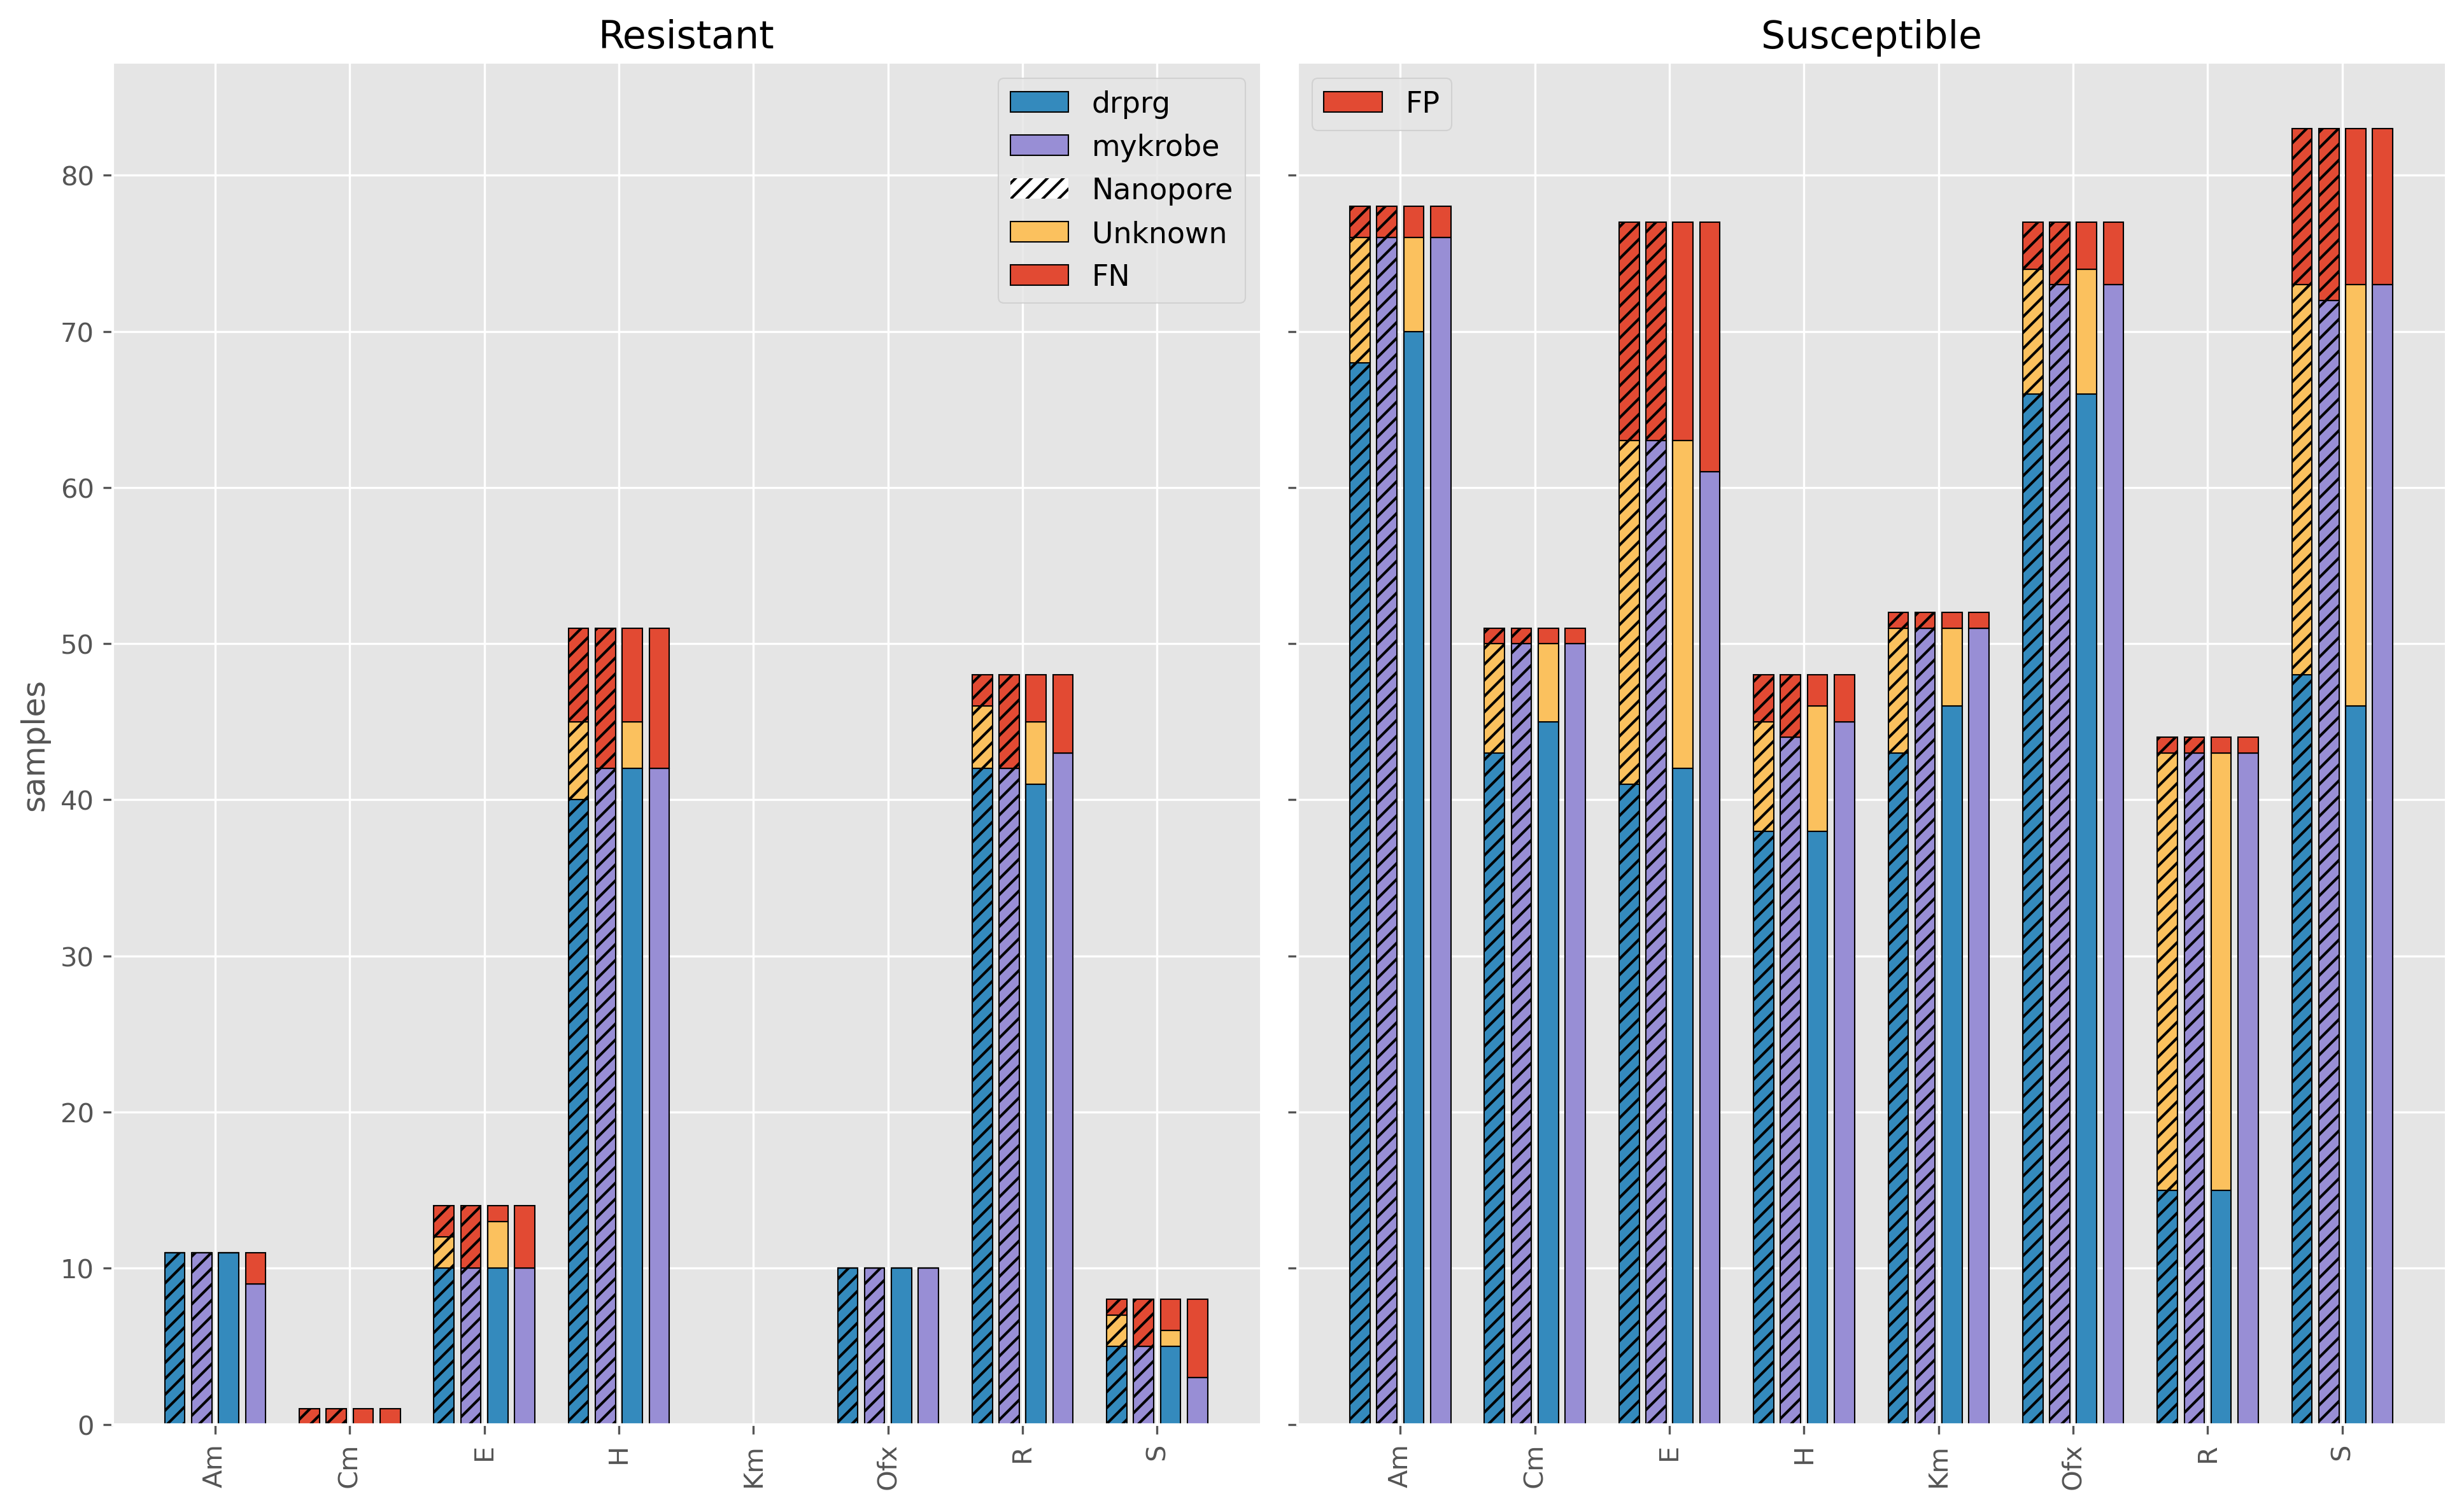

In [91]:
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
red = ggplot_cm[0]
blue = ggplot_cm[1]
black = ggplot_cm[3]
yellow = ggplot_cm[4]
green = ggplot_cm[5]
edgecol = "black"
cmap = {}
i = 0
for tool in TOOLS:
    c = ggplot_cm[i]
    if c in (red, black, yellow):
        i += 1
        c = ggplot_cm[i]
    cmap[tool] = c
    i += 1

fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.15
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    correct_novel = [
        novel_df.query("prediction == @Prediction.Unknown and classification == 'TP' and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    correct_failed = [
        novel_df.query("prediction == @Prediction.Failed and classification == 'TP' and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    incorrect_novel = [
        novel_df.query("prediction == @Prediction.Unknown and classification == 'FP'  and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    incorrect_failed = [
        novel_df.query("prediction == @Prediction.Failed and classification == 'FP'  and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    fps = [novel_cms[(d, tech, tool)].fp - incorrect_novel[i] - incorrect_failed[i] for i, d in enumerate(PHENO_DRUGS)]
    tps = [novel_cms[(d, tech, tool)].tp - correct_novel[i] - incorrect_failed[i] for i, d in enumerate(PHENO_DRUGS)]
    tns = [novel_cms[(d, tech, tool)].tn for d in PHENO_DRUGS]
    fns = [novel_cms[(d, tech, tool)].fn for d in PHENO_DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_tp_bar = axR.bar(
        positions,
        correct_novel,
        bar_width,
        bottom=tps,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_tp_bar = axR.bar(
        positions,
        correct_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tps, correct_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tps, correct_novel, correct_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )


    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_fp_bar = axS.bar(
        positions,
        incorrect_novel,
        bar_width,
        bottom=tns,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_fp_bar = axS.bar(
        positions,
        incorrect_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tns, incorrect_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tns, incorrect_novel, incorrect_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "nanopore":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_tp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_tp_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

fps_bar.set_label("FP")
fns_bar.set_label("FN")
u_tp_bar.set_label("Unknown")
# f_fp_bar.set_label("Failed")
labels = [drug_abbrev[d] for d in PHENO_DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(2, hatch_leghandle)
leglabels.insert(2, "Nanopore")
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})
sns.despine()
plt.tight_layout()

In [58]:
# fig.savefig("novel.frs70.png")

Concordance with mykrobe with novel variant calling

In [59]:
novel_df.query("prediction==@Prediction.Unknown and drug=='ethambutol'")

,sample,drug,classification,technology,coverage,tool,site,prediction
1299,mada_137,ethambutol,FP,nanopore,150.00,drprg,madagascar,U
1327,mada_144,ethambutol,FP,nanopore,150.00,drprg,madagascar,U
1359,mada_143,ethambutol,FP,nanopore,150.00,drprg,madagascar,U
1365,mada_1-18,ethambutol,FP,nanopore,55.53,drprg,madagascar,U
1371,mada_124,ethambutol,FP,nanopore,141.38,drprg,madagascar,U
1381,mada_1-6,ethambutol,FP,nanopore,150.00,drprg,madagascar,U
1391,mada_103,ethambutol,FP,nanopore,150.00,drprg,madagascar,U
1403,mada_116,ethambutol,FP,nanopore,75.66,drprg,madagascar,U
1419,mada_125,ethambutol,FP,nanopore,63.69,drprg,madagascar,U
1442,mada_110,ethambutol,FP,nanopore,45.09,drprg,madagascar,U


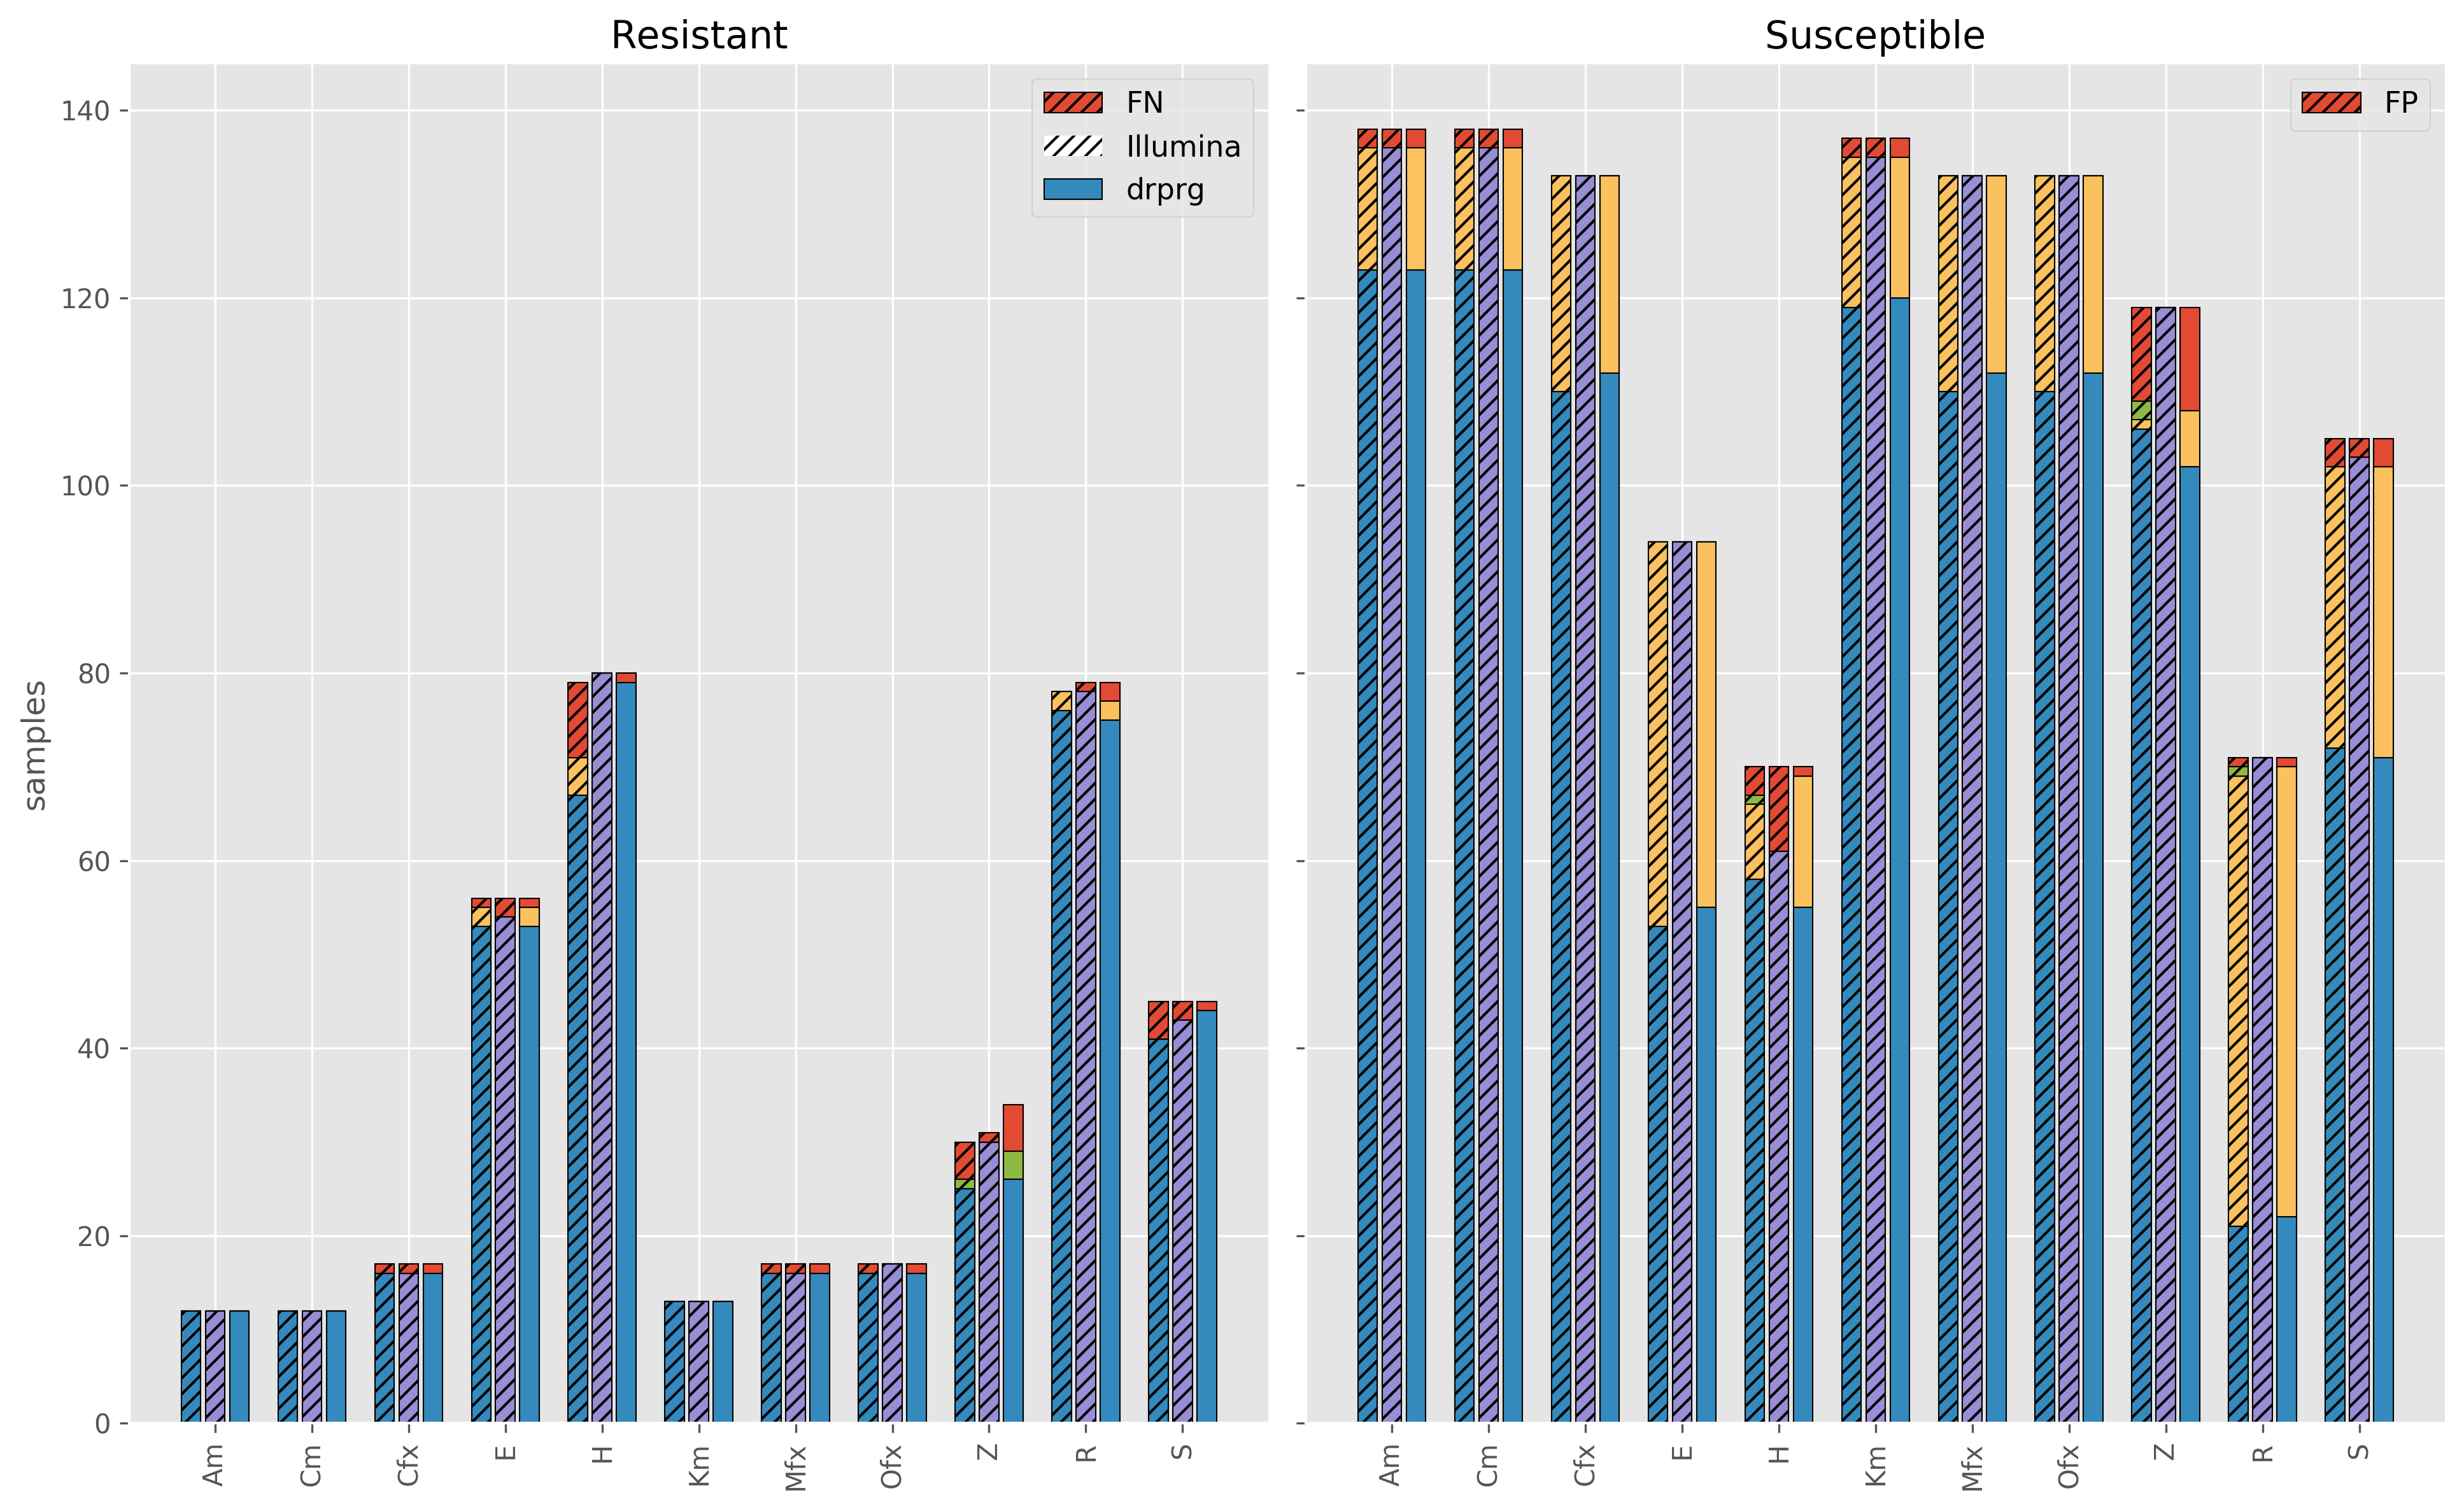

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.2
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    if (tech, tool) == ("illumina", "mykrobe"):
        continue
    correct_novel = [
        calls.query("test_call == 'U' and classification == 'FN' and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    correct_failed = [
        calls.query("test_call == 'F' and classification == 'FN' and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    incorrect_novel = [
        calls.query("test_call == 'U' and classification == 'TN'  and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    incorrect_failed = [
        calls.query("test_call == 'F' and classification == 'TN'  and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    tns = [conf_mxs[(d, tech, tool)].tn - incorrect_novel[i] - incorrect_failed[i] for i, d in enumerate(DRUGS)]
    fns = [conf_mxs[(d, tech, tool)].fn - correct_novel[i] - incorrect_failed[i] for i, d in enumerate(DRUGS)]
    tps = [conf_mxs[(d, tech, tool)].tp for d in DRUGS]
    fps = [conf_mxs[(d, tech, tool)].fp for d in DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_tp_bar = axR.bar(
        positions,
        correct_novel,
        bar_width,
        bottom=tps,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_tp_bar = axR.bar(
        positions,
        correct_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tps, correct_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tps, correct_novel, correct_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )


    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_fp_bar = axS.bar(
        positions,
        incorrect_novel,
        bar_width,
        bottom=tns,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_fp_bar = axS.bar(
        positions,
        incorrect_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tns, incorrect_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tns, incorrect_novel, incorrect_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "nanopore":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_tp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_tp_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

    if i == 0:
        fps_bar.set_label("FP")
        fns_bar.set_label("FN")
        
labels = [drug_abbrev[d.lower()] for d in DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(3, hatch_leghandle)
leglabels.insert(3, "Illumina")
leglabels.insert(3, leglabels.pop(1))
leghandles.insert(3, leghandles.pop(1))
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})

sns.despine()
plt.tight_layout()

In [61]:
fp_samples = set(novel_df.query("classification == 'FP'")["sample"])

In [62]:
[
        calls.query("test_call == 'U' and classification == 'TP' and tech == 'nanopore' and tool == 'drprg' and drug == @d").count()[0]
        for d in DRUGS
    ]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [63]:
set(calls.query("test_call == 'U'")["classification"])

{'FN', 'TN'}

In [64]:
xs = []
for sample in fp_samples:
    print(sample)
    sample_df = novel_df.query("sample == @sample and classification == 'FP'")
    fp_drugs = set(sample_df["drug"])
    print(f"FP to {fp_drugs}")
    xs.append(len(fp_drugs))

mada_113
FP to {'streptomycin'}
mada_1-16
FP to {'streptomycin'}
mada_116
FP to {'streptomycin', 'ethambutol', 'rifampicin'}
R21363
FP to {'isoniazid'}
mada_136
FP to {'rifampicin', 'ethambutol', 'isoniazid'}
mada_1-54
FP to {'streptomycin', 'ethambutol'}
R15311
FP to {'ofloxacin'}
mada_141
FP to {'rifampicin'}
mada_1-28
FP to {'ethambutol'}
mada_130
FP to {'ofloxacin'}
mada_107
FP to {'rifampicin', 'isoniazid'}
mada_2-50
FP to {'amikacin', 'streptomycin', 'ethambutol', 'capreomycin', 'kanamycin'}
mada_1-19
FP to {'streptomycin', 'ethambutol'}
R27252
FP to {'amikacin'}
mada_132
FP to {'streptomycin'}
mada_142
FP to {'streptomycin', 'ethambutol', 'rifampicin'}
R23146
FP to {'ofloxacin'}
mada_1-20
FP to {'streptomycin', 'ethambutol', 'ofloxacin'}
mada_1-14
FP to {'amikacin', 'streptomycin', 'ethambutol', 'capreomycin', 'kanamycin'}
R36431
FP to {'rifampicin', 'ethambutol', 'isoniazid'}
mada_103
FP to {'streptomycin', 'ethambutol'}
mada_2-1
FP to {'streptomycin'}
mada_1-22
FP to {'capreom

In [65]:
df = pd.DataFrame(pheno_clf, columns=["sample", "drug", "classification", "tech", "covg", "tool", "site"])

In [66]:
d = defaultdict(list)
for i, row in df.query("classification == 'FP'").iterrows():
    d[row["drug"]].append((row["sample"], row["tool"], row["tech"]))

In [67]:
upset_data = upsetplot.from_contents(d)

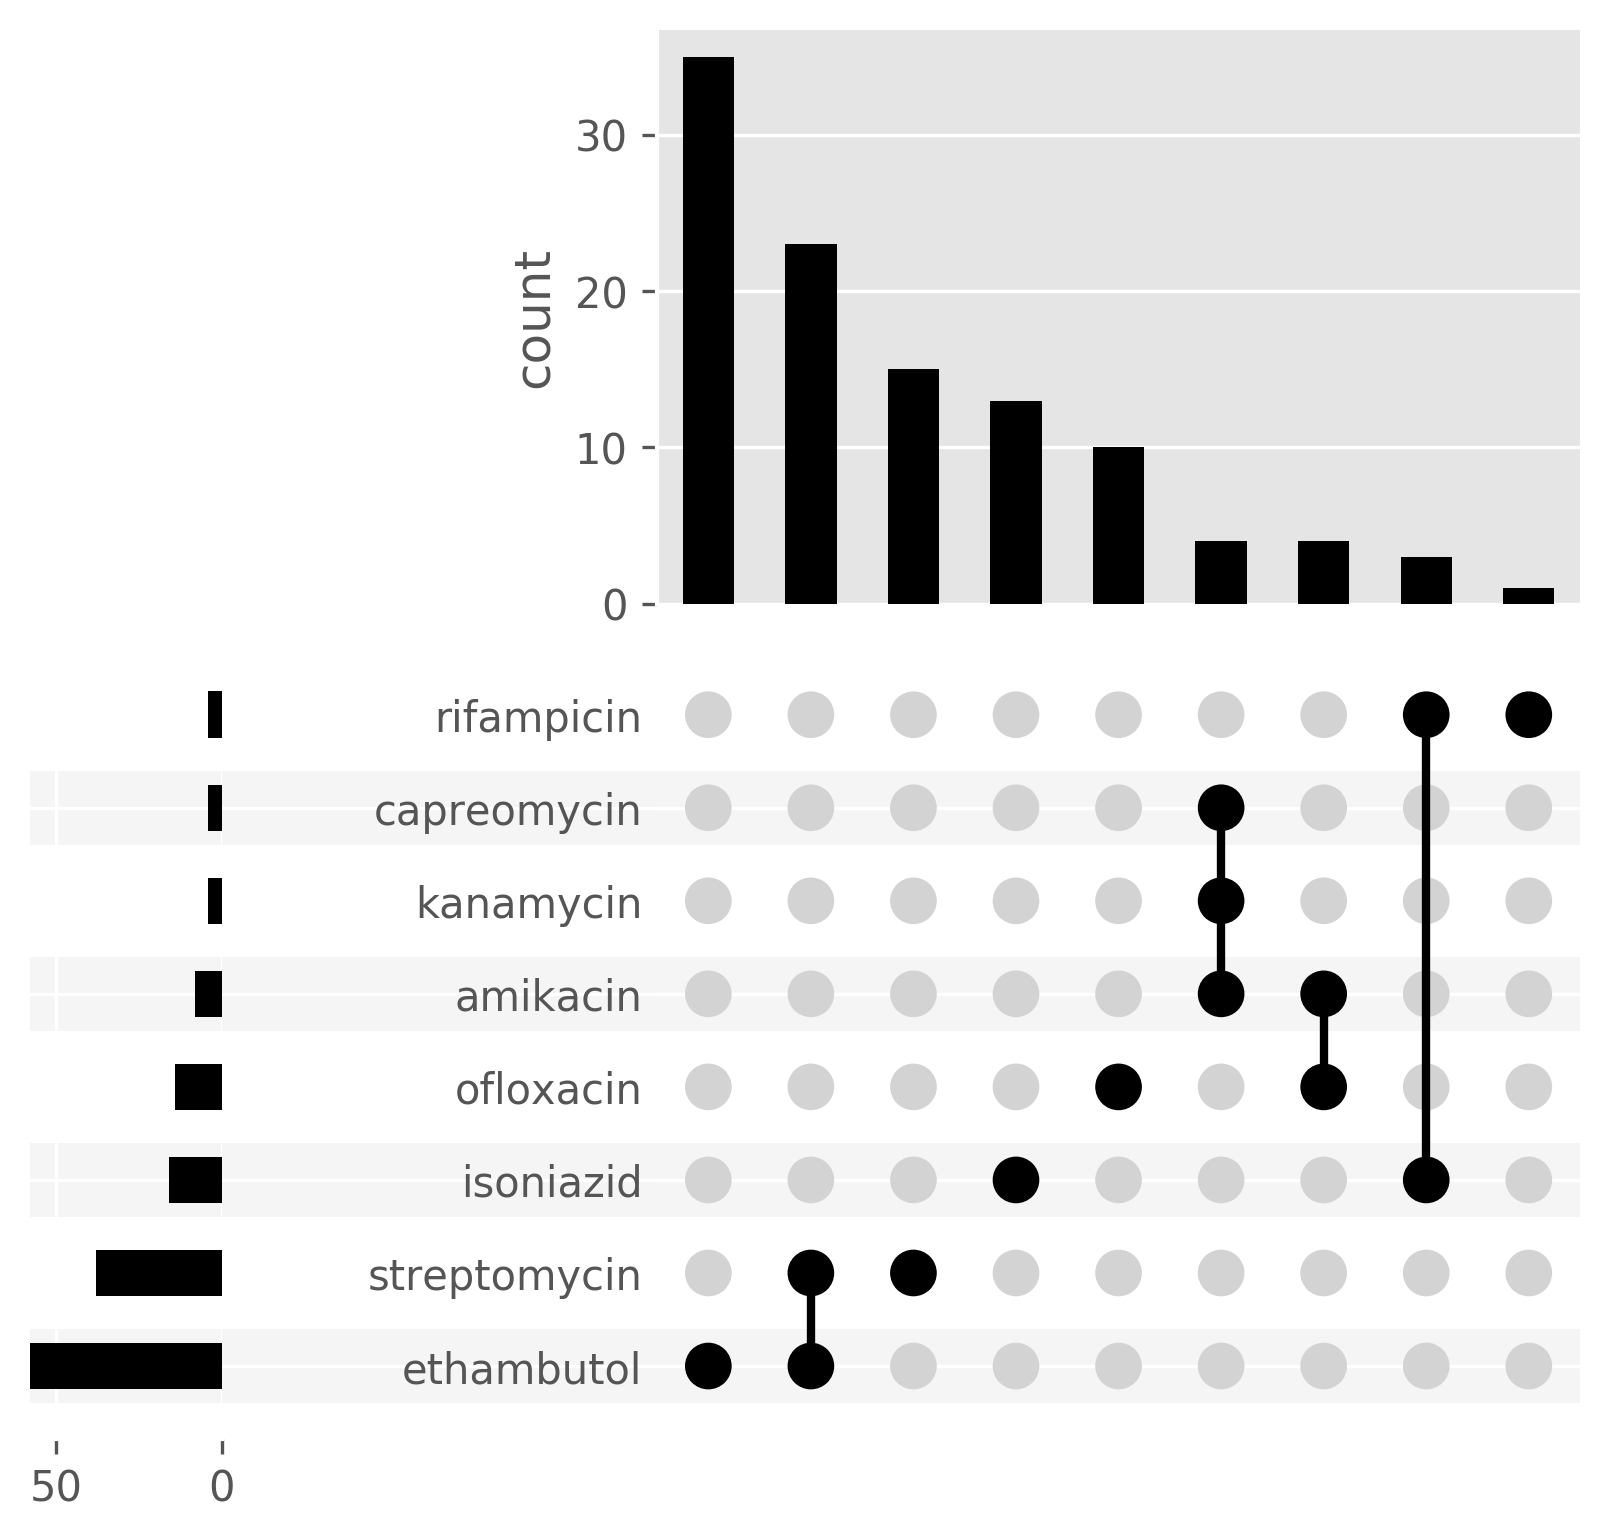

In [68]:
fig, ax = plt.subplots()
p = upsetplot.plot(
    upset_data,
    fig=fig,
    sort_by="cardinality",
    orientation="horizontal",
)
p["intersections"].set_ylabel("count")
ax.axis("off")
# fig.set_figwidth(8)
# fig.set_figheight(10)
fig.set_dpi(300)

Pull out the susceptible variants in the WHO panel and create a panel for them

In [69]:
p = "/Users/michaelhall/Downloads/catalogue.tsv"

In [70]:
# genes = set()
# with open("/Users/michaelhall/Downloads/panel.tsv") as f:
#     for row in f:
#         gene = row.split("\t")[0]
#         genes.add(gene)

In [71]:
# def is_indel(v):
#     return "ins" in v or "del" in v

# def which_residue(v):
#     if v[0].islower():
#         return "DNA"
#     else:
#         return "PROT"
    
# def convert_indel(v):
#     if not is_indel(v):
#         return v
#     fields = v.split("_")
#     pos = fields[0]
#     ref = fields[3]
#     alt = fields[4]
#     diff = int(fields[2])
#     delta_len = abs(len(ref)-len(alt))
#     if diff != delta_len:
#         raise ValueError(f"Allele length diff is {delta_len}: {v}")
#     return f"{ref}{pos}{alt}"

# def is_susceptible(grading):
#     return "Not assoc w R" in grading

In [72]:
# variants = set()
# with open(p) as f:
#     _ = next(f)
#     for row in map(str.rstrip, f):
#         _, variant, grading = row.split("\t")
#         if not is_susceptible(grading):
#             continue

#         gene, var = variant.split("_", maxsplit=1)
#         if gene not in genes:
#             continue
#         try:
#             var = convert_indel(var)
#         except ValueError:
#             print(f"Skipping {variant}")
#             continue
#         residue = which_residue(var)
#         if "(" in var:
#             var = var.split()[0]
#         variants.add((gene, var.upper(), residue, "NONE"))
        

In [73]:
# with open("/Users/michaelhall/Projects/head_to_head_pipeline/analysis/resistance_prediction/resources/non_resistant.tsv", "w") as fout:
#     for row in variants:
#         print("\t".join(row), file=fout)

In [74]:
# len(variants)

In [75]:
# for v in variants:
#     if v[0].startswith("gyrA"):
#         print(v)